In [ ]:
pip install nibabel 


In [ ]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Mounted at /content/gdrive/


In [ ]:
from skimage import measure
from skimage.morphology import skeletonize_3d
import matplotlib.pyplot as plt
from skimage.util import invert
import skimage.morphology
import nibabel as nib
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import circle

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.transform import pyramid_reduce, resize


from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_otsu

Read a 3D image using the get_data method: 




In [ ]:
def read_img(path):
  img = nib.load(path)
  return img.get_fdata()

In [ ]:
img = read_img('/content/gdrive/MyDrive/Targil1_data/HardCase2_CT.nii.gz')
img.shape

(512, 512, 209)

In [ ]:
from skimage.transform import pyramid_reduce, resize
def resize_img(img):
  h,w,d = img.shape
  return resize(img, output_shape=(h//4, w//4, d//4), preserve_range=True)

Then we have a look at slices over the first, second and third dimensions of the array.

In [ ]:
import matplotlib.pyplot as plt

def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
      axes[i].imshow(slice.T, cmap="gray", origin="lower")
      
def my_show(img_data):
  h,w,d = img_data.shape
  slice_0 = img_data[h//2, :, :]
  slice_1 = img_data[:, w//2, :]
  slice_2 = img_data[:, :, d//2]
  show_slices([slice_0, slice_1, slice_2])
  plt.suptitle("Center slices for EPI image")

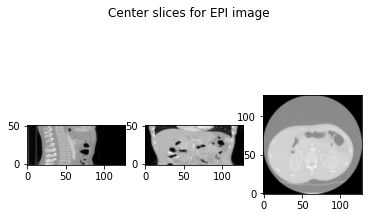

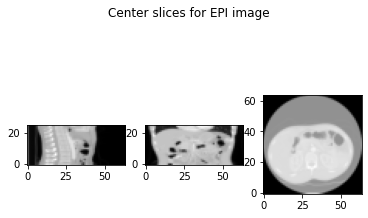

In [ ]:
my_show(img)
new_img = resize_img(img)
my_show(new_img)

#Part 1: Compute the ROI for the chest bones

IsolateBody: Isolate the patient’s body from the air and scan gantry
Input: CT Scan
Output: Body segmentation
Algorithm
1. Perform thresholding to remove all pixels with gray level (HU) below -500 and above 2000 (keep only those between -500 and 2000)
2. Filter out noise
3. Compute the largest connected component

In [ ]:
import numpy as np
from termcolor import colored
import nibabel as nib

def SegmentationByTH(img, Imin=-500, Imax=2000):
    """This function gets an image, reads it's data and perform thresholding. 
    All voxels that their values are between -500 to 2000 are taken, and the others not."""
    data_img = img.get_fdata()
    im = np.where((data_img<=Imax) & (data_img>=Imin),1 , 0)
    my_show(im)
    print("Image after thresholding")
    return im

def post_processing(data_img):
  """This function gets an iamge as input and finds min_size in order to be left
  with single connectivity component. It performes morphological operations and
  return an image with one connectivity component"""
  h,w,d = data_img.shape
  num_of_pixels = h*w*d
  num_of_non_zero = np.count_nonzero(data_img)
  # num_of_black_pixels = num_of_pixels - num_of_non_zero
  min_size = num_of_non_zero//(2*d)
  print("min size is ",min_size)
  print("Before morphologic operations  ",measure.label(data_img, return_num=True)[1])
  data_img = data_img.astype(bool)
  # data = skimage.morphology.remove_small_holes(data_img, min_size, connectivity=1)
  # print("after remove_small_holes ",measure.label(data, return_num=True)[1])
  data = skimage.morphology.remove_small_objects(data_img, min_size=min_size, connectivity=1)
  print("after remove_small_objects ",measure.label(data, return_num=True)[1])
  my_show(data)
  # print("Image left with a single connectivity component")
  return data

def IsolateBody(nifty_file):
  """This function gets a nifty file path as input, reads it, perforn thresholding
  to be left with the body only. It blures it and perform morphological operation.
  Finally, it saves the resulted image and outputs it."""
  mount_path = '/content/gdrive/MyDrive/Targil1_data/'
  nifty_file_nii = nifty_file + '.nii.gz'
  path =  mount_path + nifty_file_nii
  img = nib.load(path)
  canonical_img = nib.as_closest_canonical(img)
  # Perform thresholding to remove all pixels with gray level (HU) below -500
  # and above 2000 (keep only those between -500 and 2000)
  thresh_im = SegmentationByTH(canonical_img)
  # Filter out noise
  blur_im = gaussian_filter(thresh_im, sigma=1)
  # Compute the largest connected component
  new_im = post_processing(blur_im)
  #creating new NiftiImage
  new_nifti = nib.Nifti1Image(new_im.astype('<f8'), canonical_img.affine)
  #saving the nifti file.
  name  = nifty_file + '_IsolateBody.nii.gz'
  nib.save(new_nifti, name) 
  return new_im,canonical_img
  

IsolateBS: Isolate the lungs

Input: body segmentation from IsolateBody

Output: (a) The lungs segmentation
        (b) The BB and CC cross-sections slices

Algorithm
1. Find the two large cavities inside the body segmentation which correspond to the lungs
2. Define two cross-sections above the lungs segmentation: the plane BB corresponds to the
inferior slice of the lungs; the plane CC corresponds to the widest slice of the lungs (see
Figure below)
3. The plane CC is the last slice/slice in which the lungs slice does not change much (or close
to it).

In [ ]:
def lungs_segmentation(IsolateBody_seg,nifty_file,img):
  """This function gets the segmentation of the body and returns a segmentation of the lungs.
  Based on the fact the the lungs have air inside, therefor the voxels are black.
  So it finds the slices where there are the most black voxels."""
  h,w,d = IsolateBody_seg.shape
  max = 0
  BB_ind = 0
  for i in range(d):
    count = np.count_nonzero(IsolateBody_seg[:,:,i])
    if(count>max):
      max = count
      BB_ind = i
  cropped = IsolateBody_seg[:,:,BB_ind:]
  res = np.ones_like(IsolateBody_seg)
  # res = np.zeros_like(IsolateBody_seg)
  res[:,:,BB_ind:] = cropped
  final_res = np.where(res,0,1)
  my_show(final_res)
  #creating new NiftiImage
  new_nifti = nib.Nifti1Image(final_res.astype('<f8'), img.affine)
  #saving the nifti file.
  name  = nifty_file + '_lungs_segmentation.nii.gz'
  nib.save(new_nifti, name)
  return final_res

def IsolateBS(IsolateBody_seg,nifty_file,img,is_small,resize_by):
  if is_small:
    h,w,d = IsolateBody_seg.shape
    IsolateBody_seg = resize(IsolateBody_seg, output_shape=(h//resize_by, w//resize_by, d//resize_by), preserve_range=True)
    # IsolateBody_seg = resize(IsolateBody_seg, output_shape=(h//4, w//4, d//4), preserve_range=True)
    # IsolateBody_seg = resize(IsolateBody_seg, output_shape=(h//3, w//3, d//3), preserve_range=True)
  h,w,d = IsolateBody_seg.shape
  max = 0
  BB_ind = 0
  for i in range(d):
    count = np.count_nonzero(IsolateBody_seg[:,:,i])
    if(count>max):
      max = count
      BB_ind = i
  print(BB_ind)
  min = max
  CC_ind = 0
  for i in range(d):
    count = np.count_nonzero(IsolateBody_seg[:,:,i])
    if(count<min and count>0):
      min = count
      CC_ind = i
  max_w = 0
  widest_ind = 0
  for i in range(w):
    count = np.count_nonzero(IsolateBody_seg[:,i,:])
    if(count>max_w and count>0):
      max_w = count
      widest_ind = i
  print(CC_ind)
  lungs_seg = lungs_segmentation(IsolateBody_seg,nifty_file,img)
  # res = np.ones_like(IsolateBody_seg)
  # res[:,w_min_ind:widest_ind,BB_ind:CC_ind] = IsolateBody_seg[:,w_min_ind:widest_ind,BB_ind:CC_ind]
  # final_res = np.where(res,0,1)
  # my_show(final_res)
  # return BB_ind, CC_ind,w_min_ind,widest_ind,lungs_seg,final_res
  return BB_ind, CC_ind,widest_ind,lungs_seg

ThreeDBand: 3D band around the lungs

Input: 

  1) Body segmentation from IsolateBody

  2) Lungs segmentation from IsolateBS.

  3) Planes BB and CC (slice indices)

Output: 3D band around the lungs

Algorithm: from slice BB to slice CC, extract the region confined between the body and the
convex hull of the lungs 

In [ ]:
def ThreeDBand(IsolateBody_seg, lungs_seg, CC_ind, BB_ind,img,nifty_file):
  res = np.ones_like(IsolateBody_seg)
  ThreeDBand_lungs = IsolateBody_seg[:,:,BB_ind:CC_ind]
  res[:,:,BB_ind:CC_ind] = ThreeDBand_lungs
  final_res = np.where(res,0,1)
  my_show(final_res)
  #creating new NiftiImage
  new_nifti = nib.Nifti1Image(final_res.astype('<f8'), img.affine)
  #saving the nifti file.
  name  = nifty_file + '_ThreeDBand_lungs_2.nii.gz'
  nib.save(new_nifti, name)
  return final_res

# Case 1 Example

Isolate the patient’s body from the bed and the surroundings

Image after thresholding
min size is  45055
Before morphologic operations   3
after remove_small_holes  3
after remove_small_objects  1


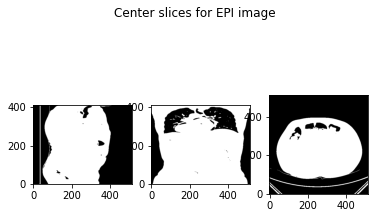

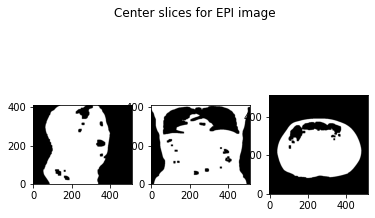

In [ ]:
nifty_file = 'Case1_CT'
IsolateBody_seg,img = IsolateBody(nifty_file)

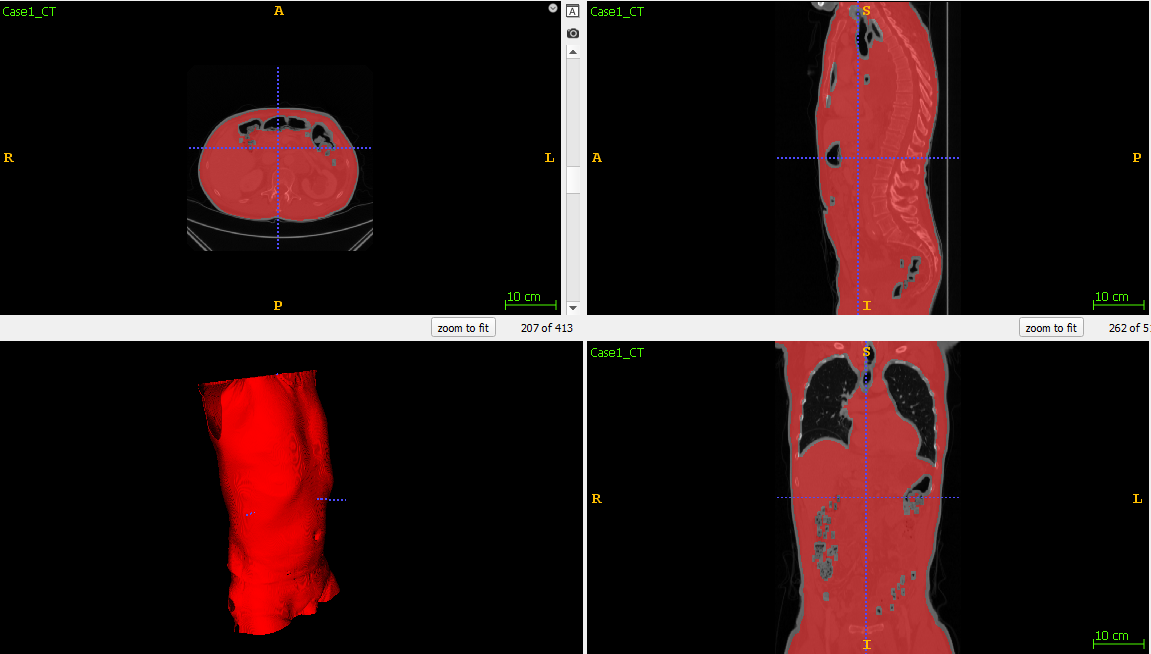

Lungs segmentation from IsolateBS

243


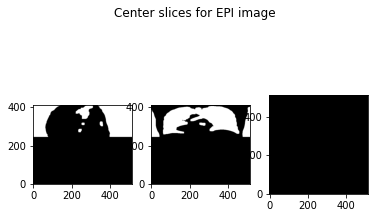

In [ ]:
lungs_segmentation(IsolateBody_seg,nifty_file,img)

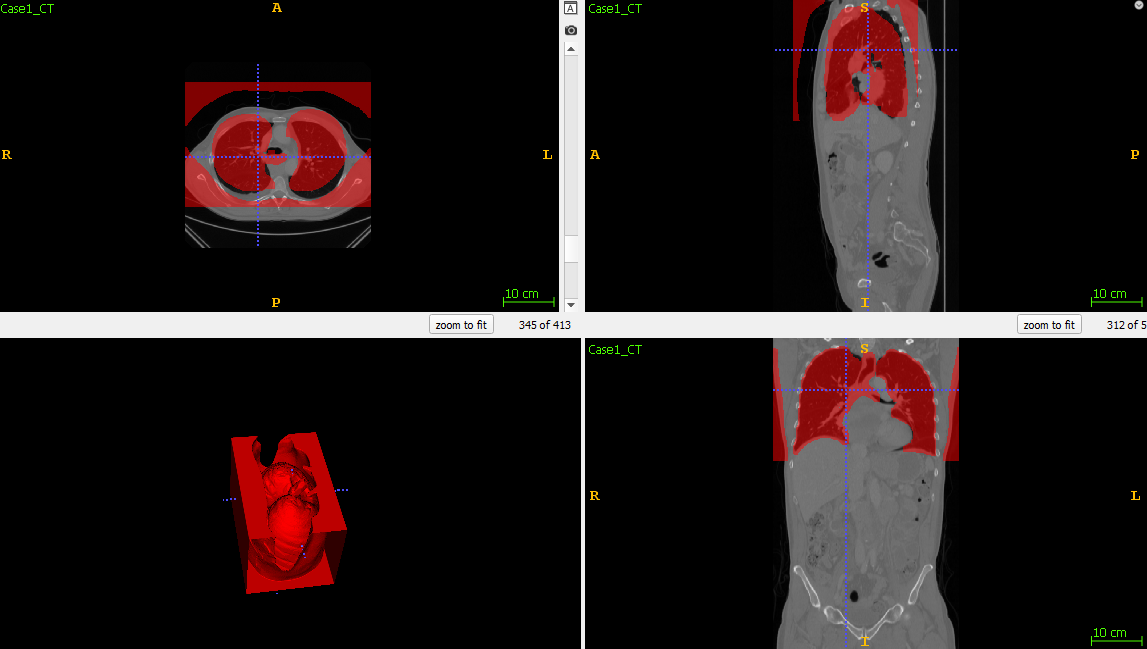

243
342


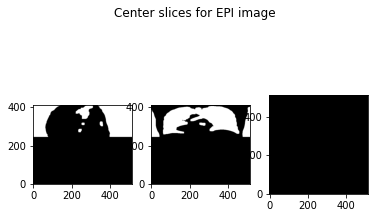

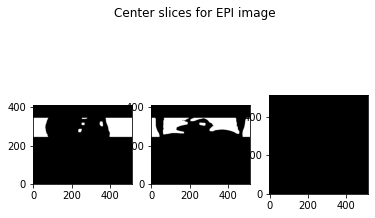

In [ ]:
BB_ind,CC_ind,lungs_seg = IsolateBS(IsolateBody_seg,nifty_file,img)
band = ThreeDBand(IsolateBody_seg, lungs_seg, CC_ind, BB_ind,img,nifty_file)

ThreeDBand - BB and CC palnes

In [ ]:
final_res = ThreeDBand(IsolateBody_seg, lungs_seg, CC_ind, BB_ind,img,nifty_file)

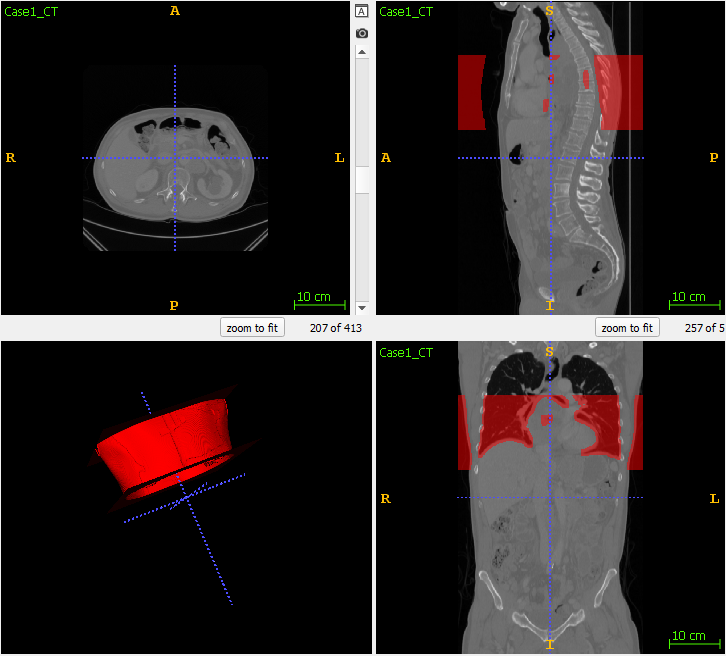

# Hard Case 1 Example

Image after thresholding
min size is  54937
Before morphologic operations   3
after remove_small_holes  3
after remove_small_objects  1


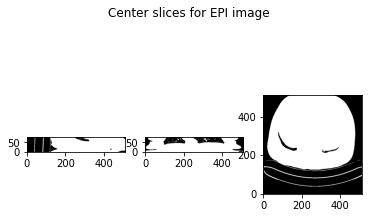

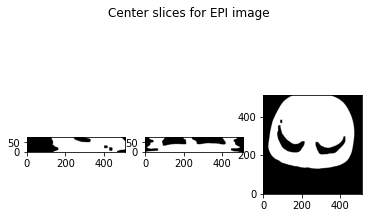

In [ ]:
IsolateBody_seg,img = IsolateBody('HardCase1_CT')

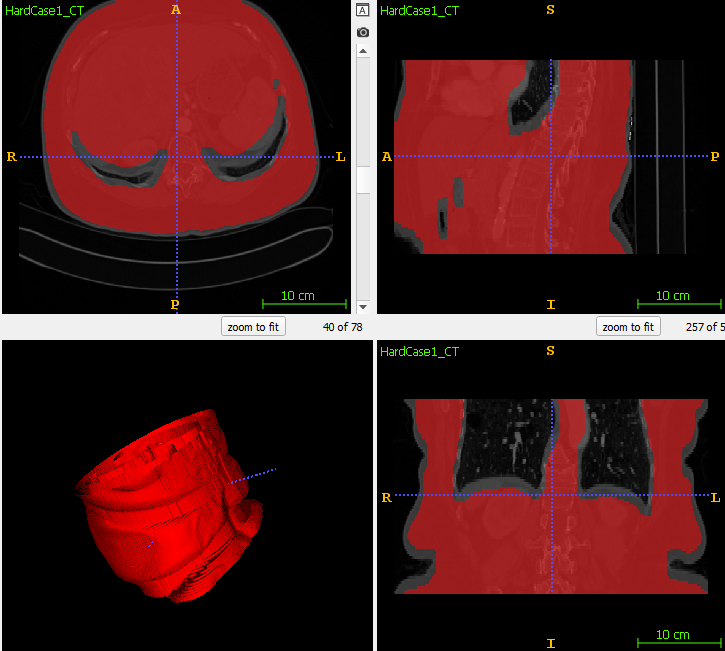

Lungs segmentation from IsolateBS

24
58


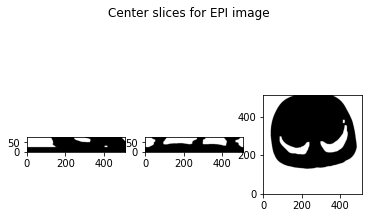

In [ ]:
BB_ind, CC_ind,widest_ind,lungs_seg = IsolateBS(IsolateBody_seg,nifty_file,img,False)

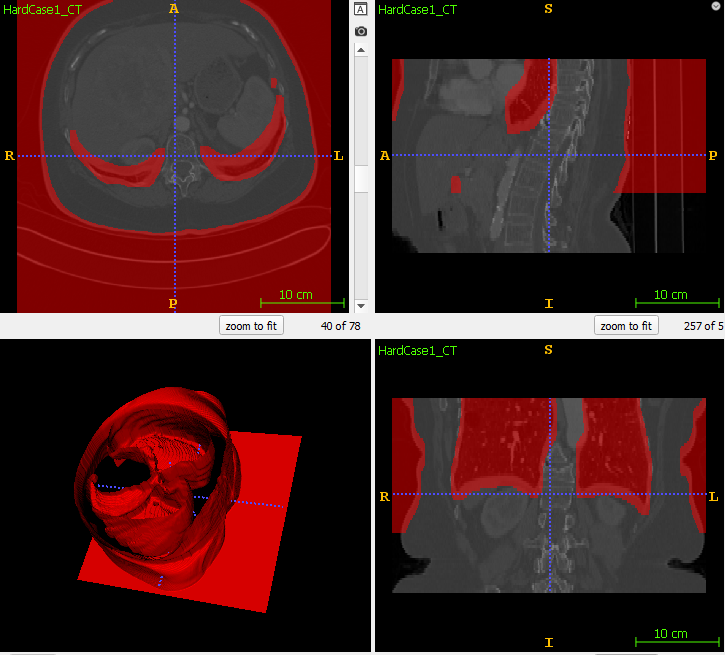

ThreeDBand - BB and CC palnes

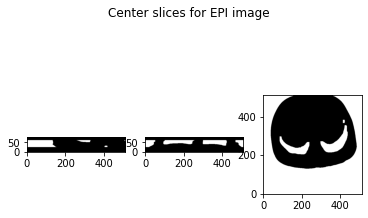

In [ ]:
final_res = ThreeDBand(IsolateBody_seg, lungs_seg, CC_ind, BB_ind,img,nifty_file)

In [ ]:
    #creating new NiftiImage
    new_nifti = nib.Nifti1Image(final_res.astype('<f8'), img.affine)
    #saving the nifti file.
    name  = 'HardCase 1' + '_BAND.nii.gz'
    nib.save(new_nifti, name)

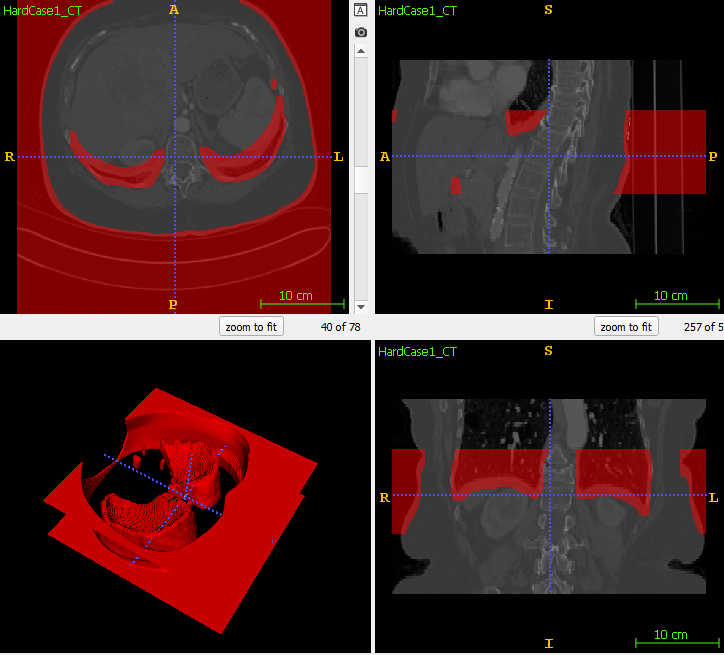

# Hard Case 2 Example

Image after thresholding
min size is  37338
Before morphologic operations   4
after remove_small_holes  4
after remove_small_objects  1


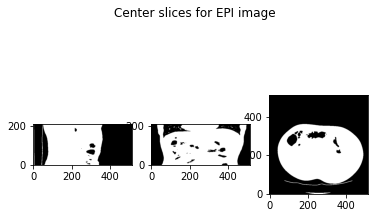

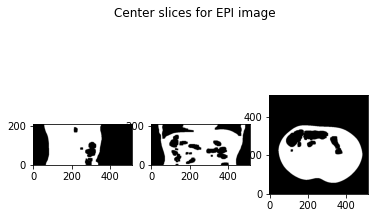

In [ ]:
nifty_file = 'HardCase2_CT'
IsolateBody_seg,img = IsolateBody(nifty_file)

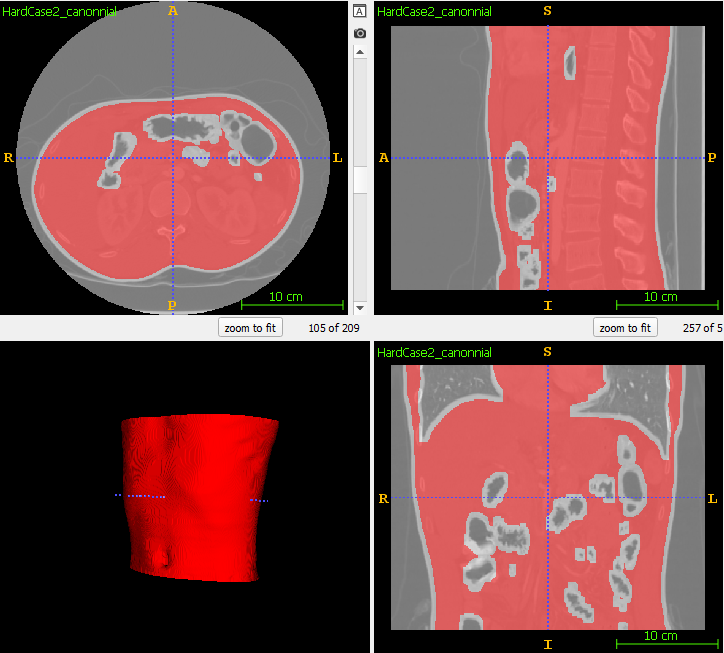

Lungs segmentation from IsolateBS

In [ ]:
BB_ind, CC_ind,widest_ind,lungs_seg = IsolateBS(IsolateBody_seg,nifty_file,img,False)

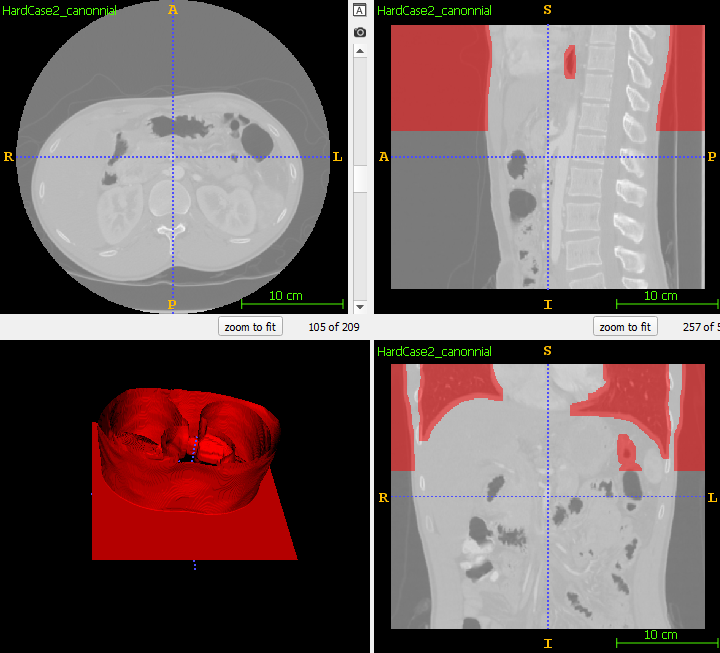

ThreeDBand - BB and CC palnes

In [ ]:
final_res = ThreeDBand(IsolateBody_seg, lungs_seg, CC_ind, BB_ind,img,nifty_file)

In [ ]:
    #creating new NiftiImage
    new_nifti = nib.Nifti1Image(final_res.astype('<f8'), img.affine)
    #saving the nifti file.
    name  = 'HardCase2' + '_BAND.nii.gz'
    nib.save(new_nifti, name)

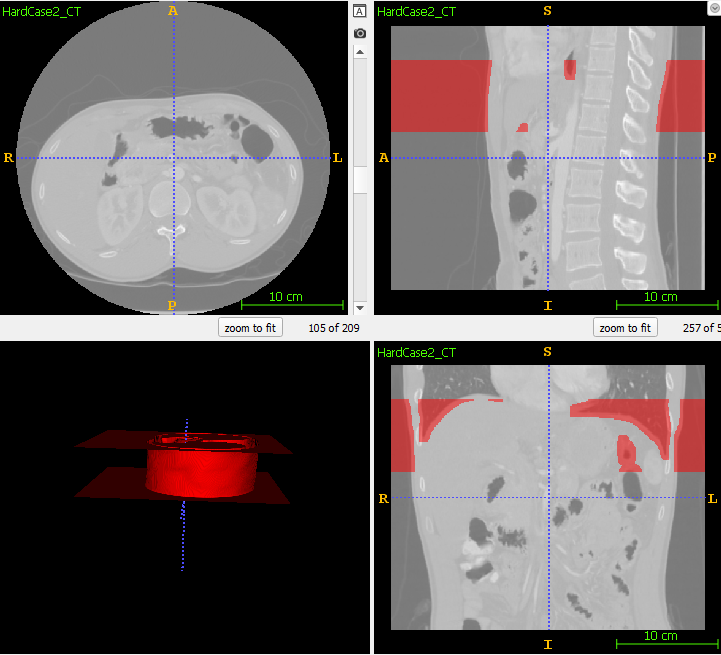

# Hard Case 3 Example

Image after thresholding
min size is  37125
Before morphologic operations   12
after remove_small_holes  12
after remove_small_objects  1


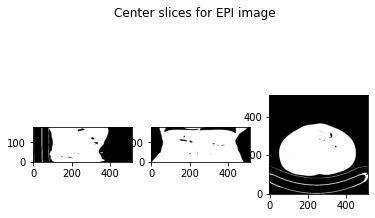

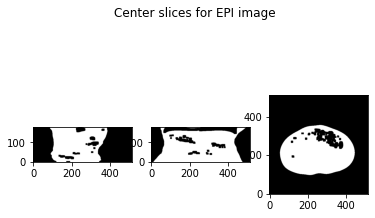

In [ ]:
nifty_file = 'HardCase3_CT'
IsolateBody_seg,img = IsolateBody(nifty_file)

# Part 1.2 Compute an ROI for the vertebrae

**Build a spine ROI**
Each CT scan includes an initial segmentation of the aorta.
Combine tools : thresholding, region growing, graph cut.

The function ‘MergedROI’ gets as input a CT scan and returns an ROI. It saves the output in a nifty file with the name format of <filename>_ROI.nii.gz


Note :  you mentioned that the first part is relevant for the liver segmentation. I couldnt figure out how finding the vertebrae can be helpfull, instead I used the information about the location of the liver relative to the aorta.

In [ ]:
def MergeROI(ct_scan,aorta):
    IsolateBody_seg,img = IsolateBody(ct_scan)
    BB_ind, CC_ind,widest_ind,lungs_seg = IsolateBS(IsolateBody_seg,ct_scan,img,True)
    # read images
    aorta_img,ct_scan_img,ct_img = read_images(ct_scan,aorta)
    h,w,d = ct_scan_img.shape
    # resize
    smaller_ct_img = resize(ct_scan_img, output_shape=(h//4, w//4, d//4), preserve_range=True)
    smaller_aorta_img = resize(aorta_img, output_shape=(h//4, w//4, d//4), preserve_range=True)
    # smaller_ct_img = resize(ct_scan_img, output_shape=(h//3, w//3, d//3), preserve_range=True)
    # smaller_aorta_img = resize(aorta_img, output_shape=(h//3, w//3, d//3), preserve_range=True)
    # my_show(smaller_ct_img)
    # my_show(smaller_aorta_img)
    ROI = find_liver_ROI(smaller_ct_img,smaller_aorta_img,BB_ind , CC_ind,widest_ind)
    # ROI = find_liver_ROI(smaller_ct_img,smaller_aorta_img,BB_ind , CC_ind,widest_ind)
    min_x,max_x,min_y,max_y,min_z,max_z=ROI
    print(min_x,max_x,min_y,max_y,min_z,max)
    # threshold
    thresh_im =  np.where((smaller_ct_img<=200) & (smaller_ct_img>=-100),smaller_ct_img , 0)
    # my_show(thresh_im)
    new_img = np.zeros_like(thresh_im)
    new_img[min_x:max_x,min_y:max_y,min_z:max_z] = 1
    my_show(new_img)
    #creating new NiftiImage
    new_nifti = nib.Nifti1Image(new_img.astype('<f8'), img.affine)
    #saving the nifti file.
    name  = ct_scan + '_ROI.nii.gz'
    nib.save(new_nifti, name)
    return new_img

Case 1

In [ ]:
ct_scan = 'Case1_CT'
aorta = 'Case1_Aorta'

Image after thresholding
min size is  45055
Before morphologic operations   3
after remove_small_objects  1
60
84
69 48 30
(58, 64, 39)
69 127 38 102 36 <built-in function max>


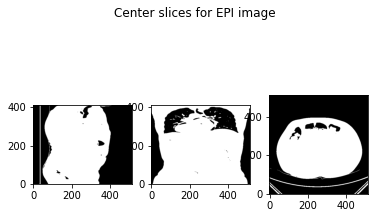

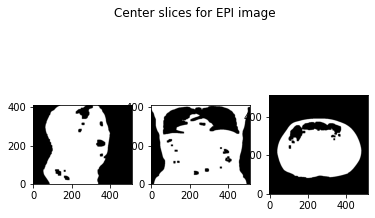

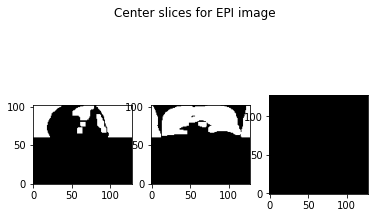

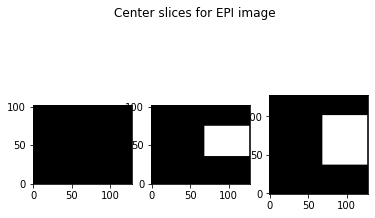

In [ ]:
my_merged_roi= MergeROI(ct_scan,aorta)

Hard Case 2

In [ ]:
ct_scan = 'HardCase2_CT'
aorta = 'HardCase2_Aorta'

Image after thresholding
min size is  37338
Before morphologic operations   4
after remove_small_objects  1
28
44
56 127 0 127 0 44
56 127 0 127 0 <built-in function max>


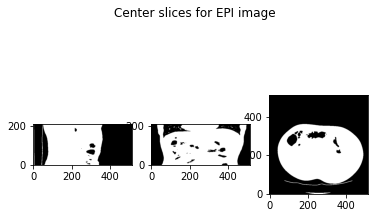

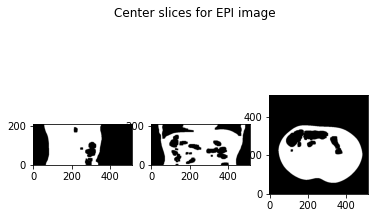

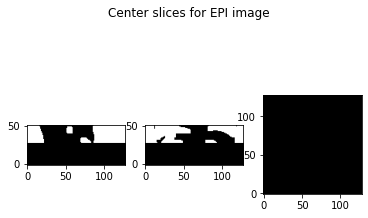

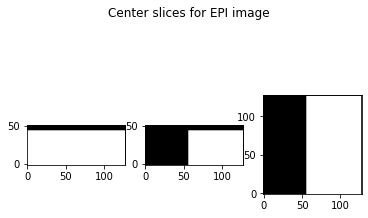

In [ ]:
my_merged_roi= MergeROI(ct_scan,aorta)

# Part 2: Region Growing Segmentation of the Liver in CT Scans 

# Liver ROI

This method is responsible for finding an ROI in the liver from which we can sample seeds for the
MSRG. 
Relevant information:
1. Typically in CT scans, the liver tissue appears in the intensity range of [−100, 200] HU
2. The liver is located to the right of the aorta, at approximately half its height


In [ ]:
def find_liver_ROI(ct_scan_img,aorta_img,BB_ind,CC_ind,widest_ind):
    """This function gets a ct image to select a ROI from.
    The ROI's depth is defined by the BB plane and CC plane which were previously found.
    The ROI width is defined by the widest index which was also previously calculated.
    It return the minimal and the maximal index in each dimention."""
    x,y,z = np.nonzero(aorta_img)
    min_z, max_z = np.min(z) , np.max(z)
    mid_z=  (max_z - min_z)//2
    min_x, max_x = np.min(x) , np.max(x)
    # print(mid_z,max_x)
    
    print(max_x,min_x,mid_z)
    # roi[max_x:,:,BB_ind- (CC_ind -BB_ind): CC_ind ] = 0
    ct_x,ct_y,ct_z = np.nonzero(ct_scan_img)
    min_x = np.max(x)
    max_x = np.max(ct_x)
    min_z,max_z =  BB_ind- (CC_ind -BB_ind),int(CC_ind*0.9)
    min_y,max_y = widest_ind,np.max(ct_z)
    # min_x,max_x = min_x + 10 , max_x - 10
    # min_y,max_y = min_y, max_y -10 
    # min_z,max_z = min_z+15,max_z-12
    print(ct_scan_img[min_x:max_x,min_y:max_y,min_z:max_z].shape)
    # my_show(ct_scan_img[min_x:max_x,min_y:max_y,min_z:max_z])
    return min_x,max_x,min_y,max_y,min_z+10,max_z-5

def find_liver_ROI_Hard(ct_scan_img,aorta_img,BB_ind , CC_ind,widest_ind):  
    """This function gets a ct image to select a ROI from.
    The ROI's depth is defined by the CC plane which were previously found.
    It return the minimal and the maximal index in each dimention.""" 
    x,y,z = np.nonzero(aorta_img)
    min_z, max_z = np.min(z) , np.max(z)
    mid_z=  (max_z - min_z)//2
    min_x, max_x = np.min(x) , np.max(x)
    ct_x,ct_y,ct_z = np.nonzero(ct_scan_img)
    # min_x = np.max(x)
    max_x = np.max(ct_x)
    min_z,max_z = np.min(ct_z) ,CC_ind
    min_y,max_y = np.min(ct_y),np.max(ct_y)
    print(min_x,max_x,min_y,max_y,min_z,max_z)
    return min_x,max_x,min_y,max_y,min_z,max_z

In [ ]:
def read_images(ct_scan,aorta):
  """This function get a path to ct_scan and a path to aorta segmnetation and
  return a data numpy array for each.
  Notice that it returns images with data reordered to be closest to canonical """
  mount_path = '/content/gdrive/MyDrive/Targil1_data/'
  ct_path =  mount_path + ct_scan + '.nii.gz'
  ct_img = nib.load(ct_path)
  ct_scan_data = nib.as_closest_canonical(ct_img)
  ct_scan = ct_scan_data.get_fdata()
  aorta_path =  mount_path +aorta + '.nii.gz'
  aorta_img = nib.load(aorta_path)
  aorta_data = nib.as_closest_canonical(aorta_img)
  aorta = aorta_data.get_fdata()
  return aorta,ct_scan,ct_img

Read images

In [ ]:
ct_scan = 'Case1_CT'
aorta = 'Case1_Aorta'

In [ ]:
  aorta_img,ct_scan_img,ct_img = read_images(ct_scan,aorta)

Resize images by dividing the height, width and depth by 4.

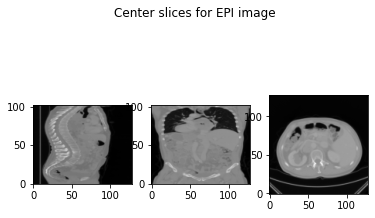

In [ ]:
from skimage.transform import pyramid_reduce, resize
h,w,d = ct_scan_img.shape
smaller_ct_img = resize(ct_scan_img, output_shape=(h//4, w//4, d//4), preserve_range=True)
smaller_aorta_img = resize(aorta_img, output_shape=(h//4, w//4, d//4), preserve_range=True)
my_show(smaller_ct_img)

Save a smaller image to apply segmentation on

In [ ]:
  img_name = 'Case 1 Smaller' + ".nii.gz"
  #creating new NiftiImage
  new_nifti = nib.Nifti1Image(smaller_ct_img.astype('<f8'), ct_img.affine)
  #saving the nifti file.
  nib.save(new_nifti, img_name)

Calculate ROI

69 48 30
(38, 54, 12)


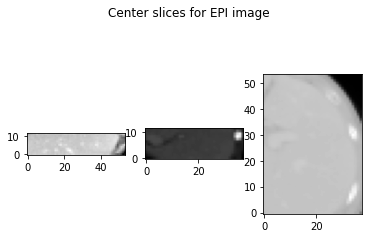

In [ ]:
ROI = find_liver_ROI(smaller_ct_img,smaller_aorta_img,BB_ind , CC_ind,widest_ind)

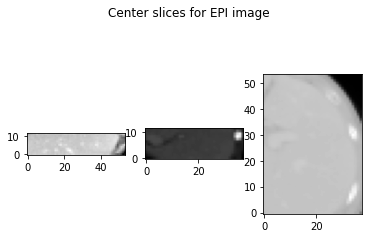

In [ ]:
min_x,max_x = ROI[0] + 10 , ROI[1] - 10
min_y,max_y = ROI[2], ROI[3] -10 
min_z,max_z = ROI[4]+15,ROI[5]-12
my_show(smaller_ct_img[min_x:max_x,min_y:max_y,min_z:max_z])

Create new image according to the ROI after thresholding.

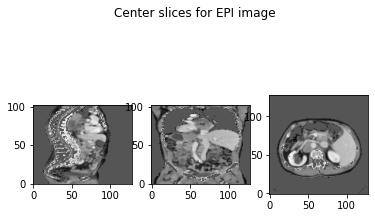

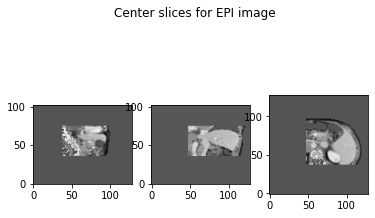

In [ ]:
  min_x,max_x,min_y,max_y,min_z,max_z=ROI
  thresh_im =  np.where((smaller_ct_img<=200) & (smaller_ct_img>=-100),smaller_ct_img , 0)
  my_show(thresh_im)
  new_img = np.zeros_like(thresh_im)
  new_img[min_x:max_x,min_y:max_y,min_z:max_z] = thresh_im[min_x:max_x,min_y:max_y,min_z:max_z]
  my_show(new_img)

In [ ]:
print(roi.shape)

(54, 61, 38)


# MSRG

findSeeds

Input: CT Scan and ROI

Output: seeds list

Algorithm: sample seeds from ROI
Start with ~200 seeds selected from you ROI. 

Sampling representive seeds is highly important in order to get good results of segmentation.
Sample randomly inside the ROI might end up with selecting seeds outside the liver. Since the ROI is calculated according to BB_plane and CC_plane it includes part of the lung. Therfore I chose a spesific area inside the liver. Moreover even selecting randomaly inside the liver might end up with bad results, if the seed is inside unhomogenous area. Using automatic seed selection might be a solution , but when I tried it the results were poor.

In [ ]:
import random

def create_seeds_list(liver_ROI,thresh_im):
  """This function gets a ROI of the liver and a ct image after thresholding and samples 200 seeds inside the ROI."""
  min_x,max_x,min_y,max_y,min_z,max_z = liver_ROI
  seeds_list = []
  i = 0 
  while (i<200):
    x_,y_,z_ = random.randint(min_x,max_x),random.randint(min_y,max_y),random.randint(min_z,max_z)
    # if(thresh_im[x_,y_,z_]>20):
    seeds_list.append([x_,y_,z_])
    i += 1
  return seeds_list

In [ ]:
def automatic_seed_selection(crop_ct):
  """This function gets a cropped ct scan after thresholding and finds a seed that has the 
  lowest gradient. Meaning it is the most homogenouse one."""
  # compute gradient of image
  gx, gy,gz = np.gradient(crop_ct[10:40,40:80,20:30])
  ind_min_gx= np.unravel_index(np.argmin(gx, axis=None), gx.shape)
  x = ind_min_gx[0]
  ind_min_gy = np.unravel_index(np.argmin(gy[x,:,:], axis=None), gy[x,:,:].shape)
  y = ind_min_gy[0]
  ind_min_gz = np.unravel_index(np.argmin(gz[x,y,:], axis=None), gz[x,y,:].shape)
  z = ind_min_gz[0]
  seed = [x,y,z]
  return seed


multipleSeedsRG

Input : 1) CT scan; 2) ROI

Output: Liver segmentation

Algorithm:

1. Extract N seeds points inside the ROI.

2. Perform Seeded Region Growing with N initial points 

The MSRG should be performed in 3D, i.e., each voxel has 26 neighbors instead of 8 in 2D

In [ ]:
from itertools import product, starmap, islice

def findNeighbors(grid, seed):
    """This function gets a seed as input and a grid - a cropped ct scan image after thresholding. 
    It search for 26 neighbours of the seed and return a list of neighbors and a list of indexs of the neighbours"""
    x,y,z = seed
    Neighbors = []
    Neighbors_ind = []
    g_x,g_y,g_z = grid.shape
    xi = (0, -1, 1) if 0 < x < g_x - 1 else ((0, -1) if x > 0 else (0, 1))
    yi = (0, -1, 1) if 0 < y < g_y - 1 else ((0, -1) if y > 0 else (0, 1))
    zi = (0, -1, 1) if 0 < z < g_z - 1 else ((0, -1) if y > 0 else (0, 1))
    for a in xi:
      for b in yi:
        for c in zi:
            if a == b == c == 0:  
                continue
            if(x+a<g_x and y + b<g_y and z+c<g_z):
              Neighbors.append(grid[x + a,y + b,z+c])
              Neighbors_ind.append([x + a,y + b,z+c])
    return Neighbors,Neighbors_ind

In [ ]:
def multipleSeedsRG(smaller_ct_img, ROI,delta):
  """This function gets a smaller ct scan (divide by 4), use threshod to keep voxels that are between -100 to 200.
  Because the liver tissue appears in this intensity range. It crops the image according to the roi that was calculated
  in early stage. Than it samples 200 seeds inside the ROI. for each seed it checks if it's neighbours are similar to the seed.
  If they are it adds them to a new image with thr shape of the ROI. Its stops after finding all voxels that are similar.
  The similarity condition is as discussed in class - |(voxel_grey_level - mean_of_neighbours)/std_of_neighbours|"""
  # min_h,min_d,max_d,widest_ind=ROI
  thresh_im =  np.where((smaller_ct_img<=200) & (smaller_ct_img>=-100),smaller_ct_img , 0)
  my_show(thresh_im)

  SL = np.zeros_like(smaller_ct_img)
  Seen = np.zeros_like(smaller_ct_img)
  h,w,d = SL.shape
  print(h,w,d)
  total_c = h*w*d
  print("Number ",total_c)
  # Label seed points using a manual method
  seeds_list = create_seeds_list(ROI,thresh_im)
  # print(seeds_list)
  add_c = 0
  seen_c = 0

  queue = []
  

  for node in seeds_list:
   
    queue.append(node)
    x,y,z = node
    Added_neighbours = np.array([x,y,z])
    Seen[x,y,z] =1
    # If queue is not empty
    while queue:
      # Remove first voxel p from the top of the queue
      seed = queue.pop(0) 
      Added_neighbours = np.concatenate((Added_neighbours,np.array(seed))) 
      # Find neighbors of seed point 
      Neighbors,Neighbors_ind = findNeighbors(smaller_ct_img, seed)
      Neighbors = np.array(Neighbors)
      # print(Neighbors.shape)

      Neighbors_count_seen = 0
      
      for n in Neighbors_ind:
          x_n,y_n,z_n = n
          if x_n<h and y_n<w and z_n<d and x_n>0 and y_n>0 and z_n>0 :
            # Add the neighbors of p that are not yet labeled to the queue according to their gray level value.
            if Seen[x_n,y_n,z_n] == 0 :
              Seen[x_n,y_n,z_n] =1
              # Test the neighbor of p
              mean = np.mean(Added_neighbours)
              std = np.std(Added_neighbours, dtype=np.float64)
              gray_level = smaller_ct_img[x_n,y_n,z_n]
              # print(gray_level,mean,std)
              homogenous_func = abs((gray_level - mean)/std).astype('float64')
              # print(homogenous_func)
              if(homogenous_func<delta):
                SL[x_n,y_n,z_n] = 1
                queue.append([x_n,y_n,z_n])
                Added_neighbours = np.concatenate((Added_neighbours,np.array(n)))  
                SL = skimage.morphology.binary_closing(SL) 
            else:
                 Neighbors_count_seen+=1  
      # If all labeled neighbors of p same label, assign this label to p        
      if Neighbors_count_seen==26 :
        SL[x,y,z] = 1
        # queue.append([x,y,z])
        SL = skimage.morphology.binary_closing(SL) 
      seen_c = np.count_nonzero(Seen)
      add_c = np.count_nonzero(SL)
      # print("seen: ",seen_c)  
      # print("added ",add_c)
  print("seen: ",seen_c)  
  print("added ",add_c)
  print("added from seen : ",add_c/seen_c)
  my_show(SL)
  return SL

# Small Case 1 Example

Smaller Image

Isolate the patient’s body from the bed and the surroundings

Image after thresholding
min size is  45055
Before morphologic operations   3
after remove_small_objects  1


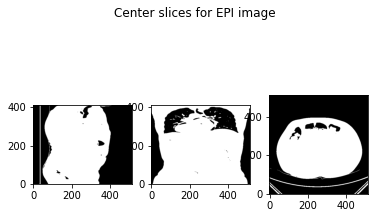

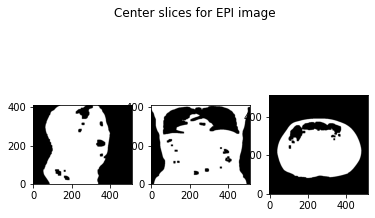

In [ ]:
nifty_file = 'Case1_CT'
IsolateBody_seg,img = IsolateBody(nifty_file)

Lungs segmentation from IsolateBS

47
66


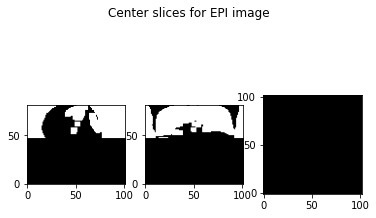

In [ ]:
BB_ind, CC_ind,widest_ind,lungs_seg = IsolateBS(IsolateBody_seg,nifty_file,img,True)

In [ ]:
ct_scan = 'Case1_CT'
aorta = 'Case1_Aorta'

In [ ]:
  aorta_img,ct_scan_img,ct_img = read_images(ct_scan,aorta)

(102, 102, 82)


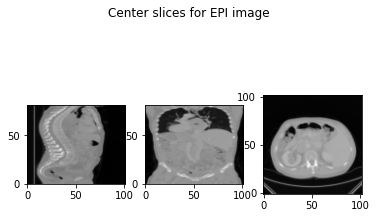

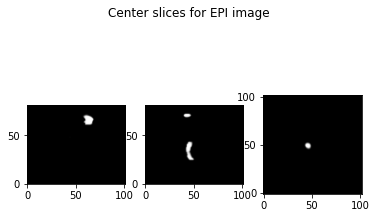

In [ ]:
from skimage.transform import pyramid_reduce, resize
h,w,d = ct_scan_img.shape
smaller_ct_img = resize(ct_scan_img, output_shape=(h//5, w//5, d//5), preserve_range=True)
smaller_aorta_img = resize(aorta_img, output_shape=(h//5, w//5, d//5), preserve_range=True)
my_show(smaller_ct_img)
my_show(smaller_aorta_img)
print(smaller_ct_img.shape)

In [ ]:
liver_ROI = find_liver_ROI(smaller_ct_img,smaller_aorta_img,BB_ind , CC_ind,widest_ind)

55 38 25
(46, 45, 31)


In [ ]:
min_x,max_x,min_y,max_y,min_z,max_z =liver_ROI
check_roi = np.zeros_like(smaller_ct_img)
check_roi[min_x:max_x,min_y:max_y,min_z:max_z ] = 1
img_name = 'Case_1_Smaller' + "check_liver_ROI_.nii.gz"
#creating new NiftiImage
new_nifti = nib.Nifti1Image(check_roi.astype('<f8'), ct_img.affine)
#saving the nifti file.
nib.save(new_nifti, img_name)

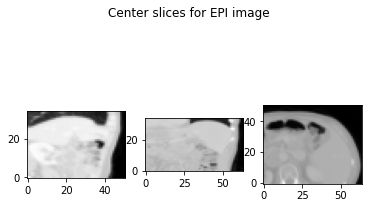

In [ ]:
min_x,max_x,min_y,max_y,min_z,max_z =liver_ROI
my_show(smaller_ct_img[min_x-15:max_x-2,min_y:max_y,min_z-7:max_z ])

In [ ]:
liver_ROI = min_x-15,max_x-2,min_y,max_y,min_z-7,max_z

Delta is 0.22 (Different ROI)

102 102 82
Number  853128
seen:  101061
added  22199
added from seen :  0.21965941362147615


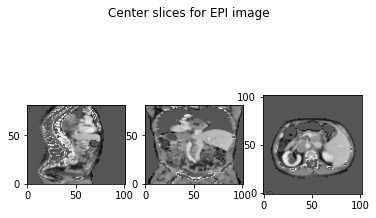

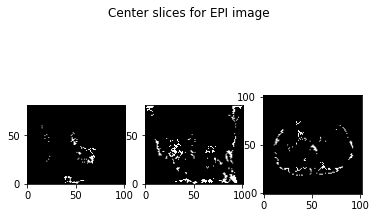

In [ ]:
liver_seg = multipleSeedsRG(smaller_ct_img, liver_ROI,0.22)

min size is  390
Before morphologic operations   15
after remove_small_objects  1


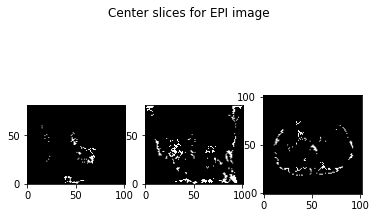

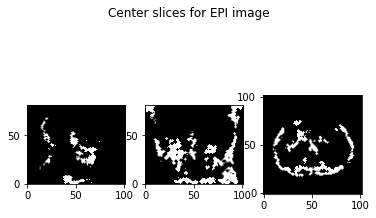

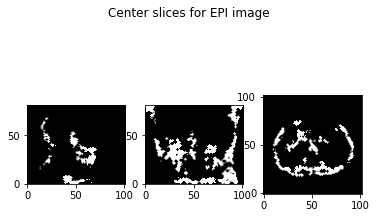

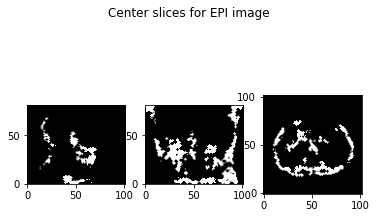

In [ ]:
my_show(liver_seg)
d = skimage.morphology.dilation(liver_seg)
b = skimage.morphology.binary_closing(d)
my_show(b)
r = post_processing(b)
my_show(r)

Delta is 0.19 (different ROI)

Image after thresholding
min size is  45055
Before morphologic operations   3
after remove_small_objects  1
47
66
55 38 25
(46, 45, 31)
102 102 82
Number  853128
seen:  13107
added  1436
added from seen :  0.10955977721828031
min size is  30
Before morphologic operations   27
after remove_small_objects  8


array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

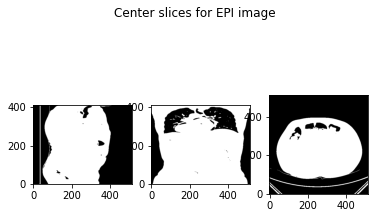

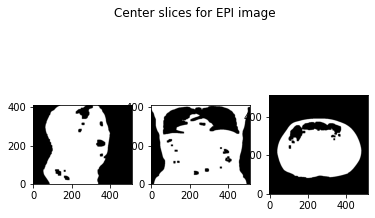

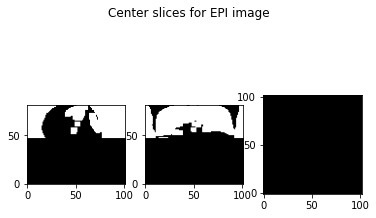

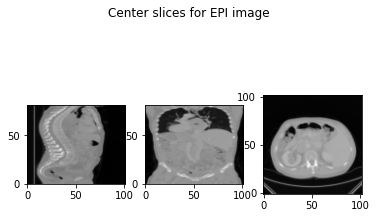

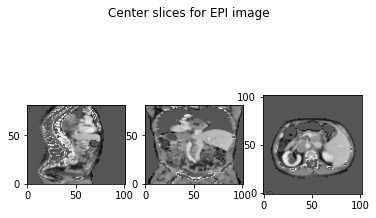

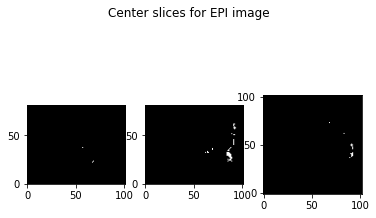

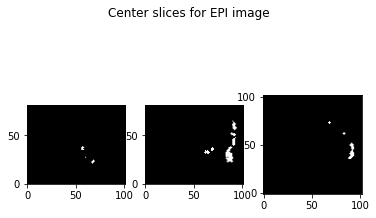

In [ ]:
ct_scan = 'Case1_CT'
aorta_seg = 'Case1_Aorta'
segmentLiver(ct_scan,aorta_seg,isHard = False ,resize_by = 5 ,delta = 0.19)

Delta is 0.165

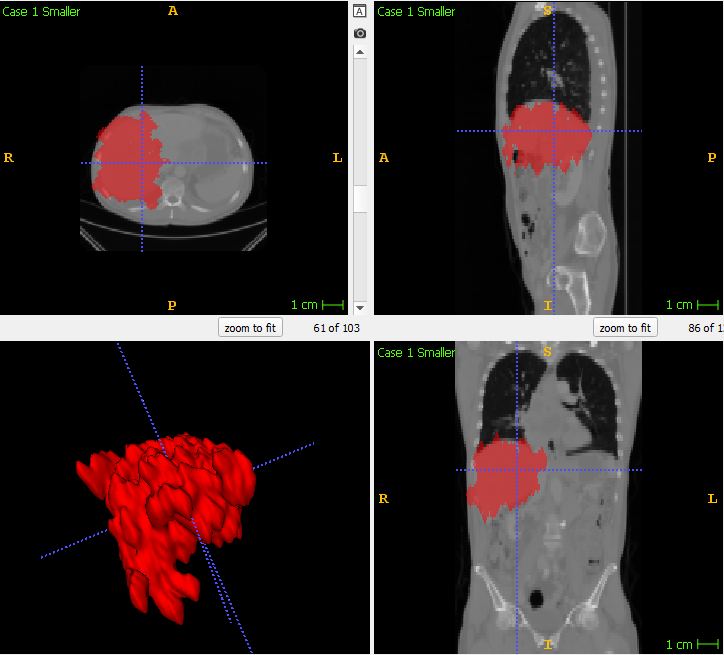

Streaming output truncated to the last 5000 lines.
seen:  23055
added  3568
seen:  23067
added  3571
seen:  23074
added  3571
seen:  23084
added  3573
seen:  23087
added  3575
seen:  23096
added  3577
seen:  23105
added  3578
seen:  23108
added  3578
seen:  23117
added  3581
seen:  23126
added  3581
seen:  23142
added  3581
seen:  23156
added  3581
seen:  23156
added  3585
seen:  23165
added  3585
seen:  23174
added  3588
seen:  23174
added  3589
seen:  23183
added  3589
seen:  23183
added  3590
seen:  23192
added  3592
seen:  23206
added  3593
seen:  23214
added  3593
seen:  23227
added  3595
seen:  23231
added  3595
seen:  23231
added  3596
seen:  23236
added  3596
seen:  23242
added  3597
seen:  23257
added  3600
seen:  23276
added  3600
seen:  23287
added  3600
seen:  23293
added  3600
seen:  23299
added  3601
seen:  23308
added  3602
seen:  23321
added  3603
seen:  23325
added  3605
seen:  23339
added  3607
seen:  23341
added  3607
seen:  23351
added  3607
seen:  23360
added  3609

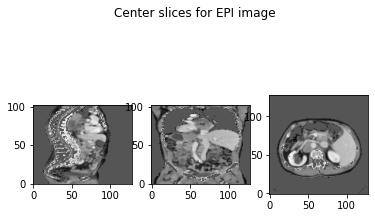

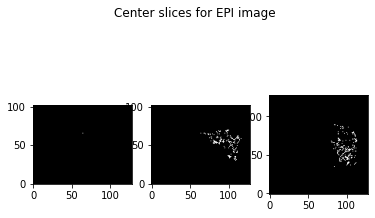

In [ ]:
liver_seg = multipleSeedsRG(smaller_ct_img, liver_ROI,0.165)

min size is  174
Before morphologic operations   8
after remove_small_objects  3


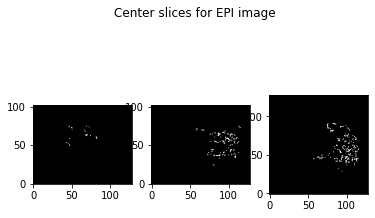

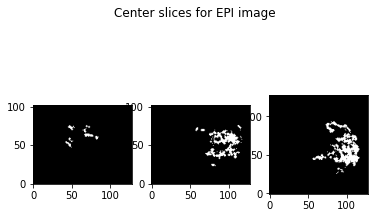

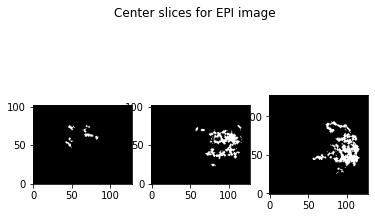

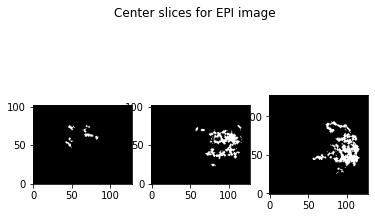

In [ ]:
my_show(liver_seg)
d = skimage.morphology.dilation(liver_seg)
b = skimage.morphology.binary_closing(d)
my_show(b)
r = post_processing(b)
my_show(r)

In [ ]:
  img_name = 'Case_1_Smaller' + "_LIVER_Seg_.nii.gz"
  #creating new NiftiImage
  new_nifti = nib.Nifti1Image(b3.astype('<f8'), ct_img.affine)
  #saving the nifti file.
  nib.save(new_nifti, img_name)

# Hard Case 1 Example

Isolate the patient’s body from the bed and the surroundings - no use of canonial

Image after thresholding
min size is  54937
Before morphologic operations   3
after remove_small_objects  1


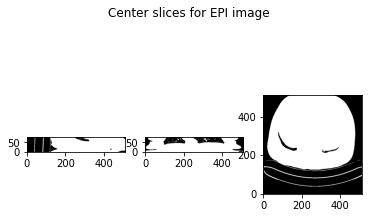

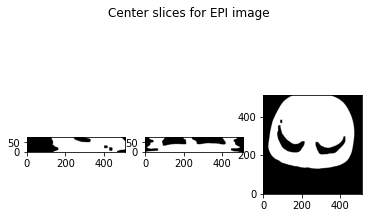

In [ ]:
nifty_file = 'HardCase1_CT'
IsolateBody_seg,img = IsolateBody(nifty_file)

Lungs segmentation from IsolateBS

9
19


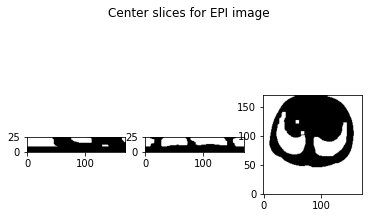

In [ ]:
BB_ind, CC_ind,widest_ind,lungs_seg = IsolateBS(IsolateBody_seg,nifty_file,img,True)

In [ ]:
print(BB_ind, CC_ind,widest_ind)

9 19 115


In [ ]:
ct_scan = 'HardCase1_CT'
aorta = 'HardCase1_Aorta'

In [ ]:
  aorta_img,ct_scan_img,ct_img = read_images(ct_scan,aorta)

(170, 170, 26)


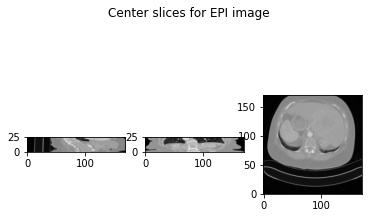

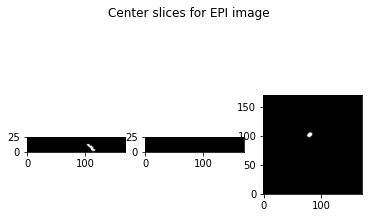

In [ ]:
h,w,d = ct_scan_img.shape
smaller_ct_img = resize(ct_scan_img, output_shape=(h//3, w//3, d//3), preserve_range=True)
smaller_aorta_img = resize(aorta_img, output_shape=(h//3, w//3, d//3), preserve_range=True)
my_show(smaller_ct_img)
my_show(smaller_aorta_img)
print(smaller_ct_img.shape)

In [ ]:
img_name = 'HardCase_1_Smaller' + ".nii.gz"
#creating new NiftiImage
new_nifti = nib.Nifti1Image(smaller_ct_img.astype('<f8'), ct_img.affine)
#saving the nifti file.
nib.save(new_nifti, img_name)

In [ ]:
liver_ROI = find_liver_ROI_Hard(smaller_ct_img,smaller_aorta_img,BB_ind , CC_ind,widest_ind)

68 169 0 169 0 19


170 170 26
Number  751400
seen:  31258
added  4470
added from seen :  0.14300339113187024


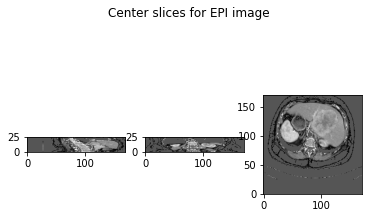

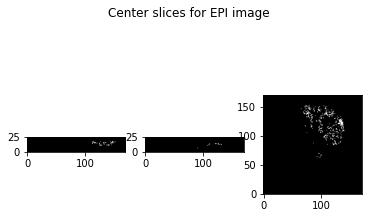

In [ ]:
liver_seg = multipleSeedsRG(smaller_ct_img, liver_ROI,0.06)

min size is  273
Before morphologic operations   11
after remove_small_objects  1


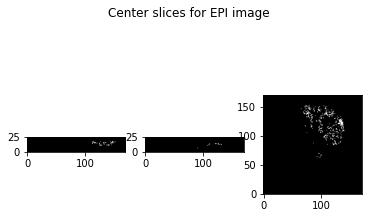

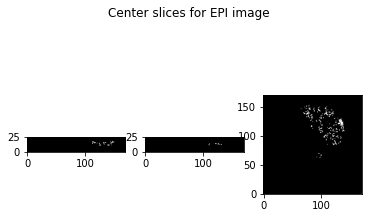

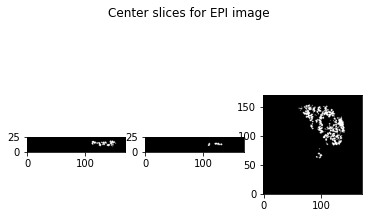

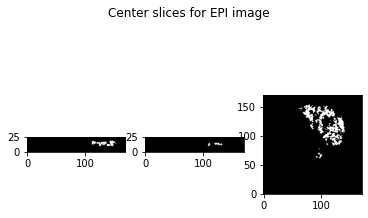

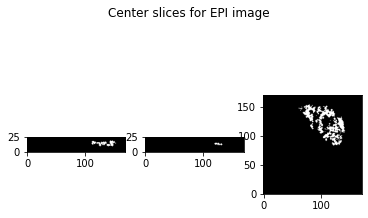

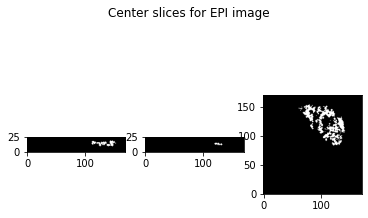

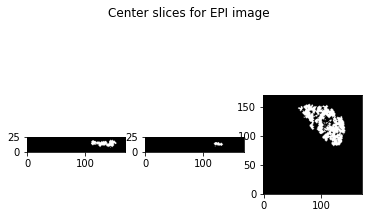

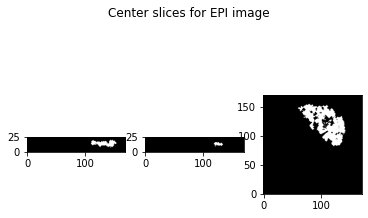

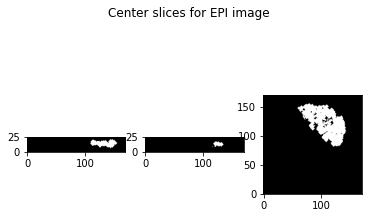

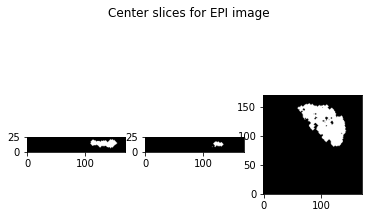

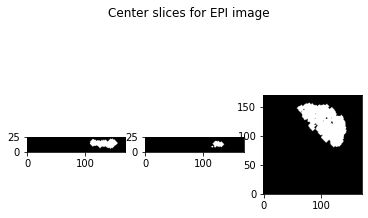

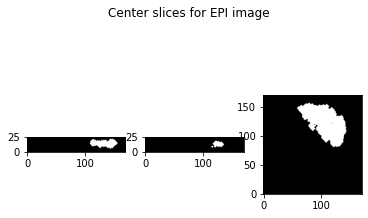

In [ ]:
my_show(liver_seg)
h = skimage.morphology.remove_small_objects(liver_seg,2)
my_show(h)
d2 = skimage.morphology.dilation(h)
my_show(d2)
b2 = skimage.morphology.binary_closing(d2)
my_show(b2)
r = post_processing(b2)
my_show(r)
d3 = skimage.morphology.dilation(r)
my_show(d3)
b3 = skimage.morphology.binary_closing(d3)
my_show(b3)
d4 = skimage.morphology.dilation(b3)
my_show(d4)
b4 = skimage.morphology.binary_closing(d4)
my_show(b4)
d5 = skimage.morphology.dilation(b4)
my_show(d5)
b5 = skimage.morphology.binary_closing(d5)
my_show(b5)

In [ ]:
print(liver_seg.shape)

(170, 170, 26)


In [ ]:
  img_name = 'HardCase_1' + "_LIVER_Seg_0.06.nii.gz"
  #creating new NiftiImage
  new_nifti = nib.Nifti1Image(b5.astype('<f8'), ct_img.affine)
  #saving the nifti file.
  nib.save(new_nifti, img_name)

delta is 0.15 - we missed some ereas the beong to the liver, and included areas that do not belong to the liver.

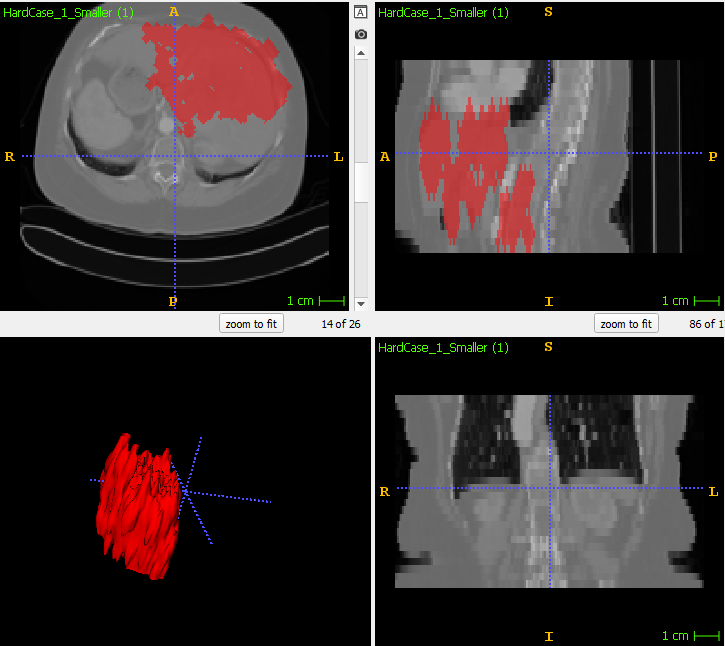

delta is 0.09 - this time we missed less ereas that belong to the liver, but included more erea that dont.

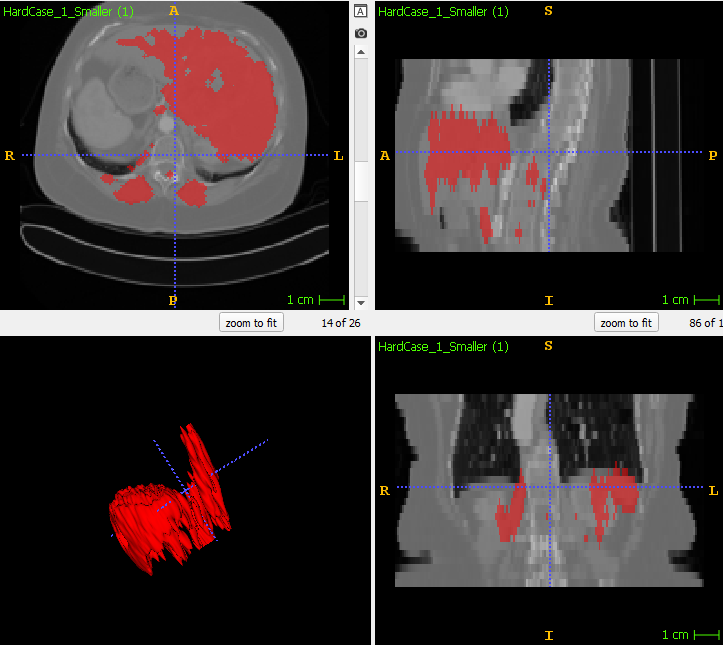

delta is 0.06 - this time we missed less ereas that belong to the liver, and included less erea that dont.

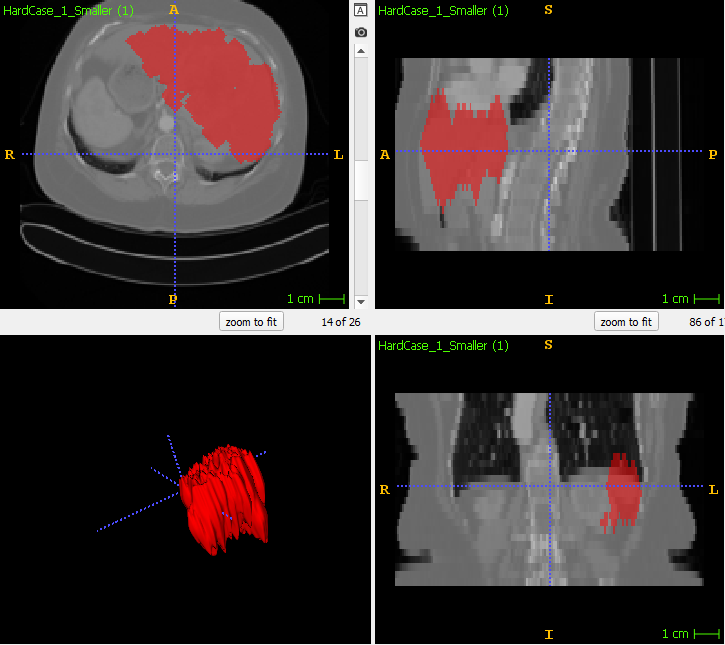

# Hard Case 2 Example

Isolate the patient’s body from the bed and the surroundings - no use of canonial

Image after thresholding
min size is  37338
Before morphologic operations   4
after remove_small_objects  1


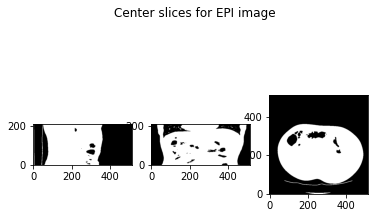

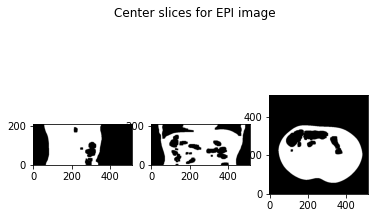

In [ ]:
nifty_file = 'HardCase2_CT'
IsolateBody_seg,img = IsolateBody(nifty_file)

Lungs segmentation from IsolateBS

28
44


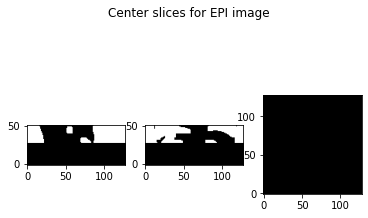

In [ ]:
BB_ind, CC_ind,widest_ind,lungs_seg = IsolateBS(IsolateBody_seg,nifty_file,img,True)

In [ ]:
print(BB_ind, CC_ind,widest_ind)

28 44 45


In [ ]:
ct_scan = 'HardCase2_CT'
aorta = 'HardCase2_Aorta'

In [ ]:
  aorta_img,ct_scan_img,ct_img = read_images(ct_scan,aorta)

(128, 128, 52)


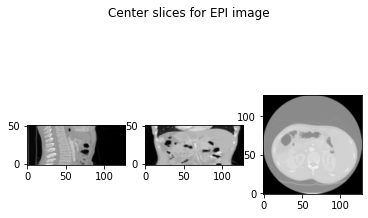

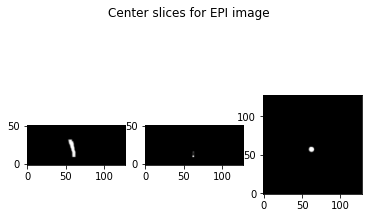

In [ ]:
h,w,d = ct_scan_img.shape
smaller_ct_img = resize(ct_scan_img, output_shape=(h//4, w//4, d//4), preserve_range=True)
smaller_aorta_img = resize(aorta_img, output_shape=(h//4, w//4, d//4), preserve_range=True)
my_show(smaller_ct_img)
my_show(smaller_aorta_img)
print(smaller_ct_img.shape)

In [ ]:
img_name = 'HardCase_2_Smaller' + ".nii.gz"
#creating new NiftiImage
new_nifti = nib.Nifti1Image(smaller_ct_img.astype('<f8'), ct_img.affine)
#saving the nifti file.
nib.save(new_nifti, img_name)

In [ ]:
liver_ROI = find_liver_ROI_Hard(smaller_ct_img,smaller_aorta_img,BB_ind , CC_ind,widest_ind)

56 127 0 127 0 44


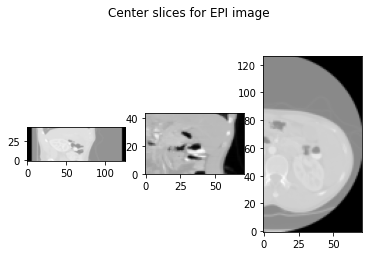

In [ ]:
minx,maxx,miny,maxy,minz,maxz=liver_ROI
my_show(smaller_ct_img[minx:maxx,miny:maxy,minz:maxz])

128 128 52
Number  851968
seen:  37843
added  7982
added from seen :  0.21092408107179664


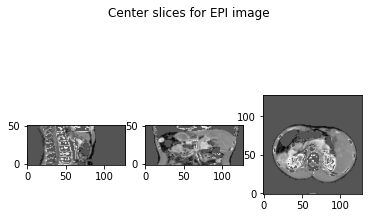

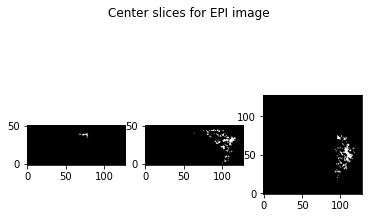

In [ ]:
liver_seg = multipleSeedsRG(smaller_ct_img, liver_ROI,0.04)

min size is  205
Before morphologic operations   12
after remove_small_objects  1


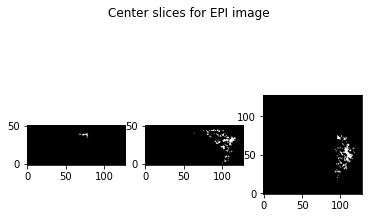

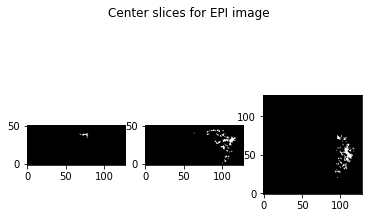

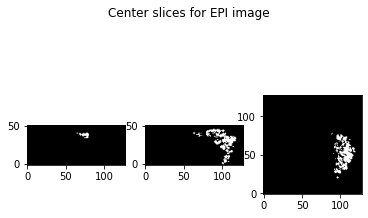

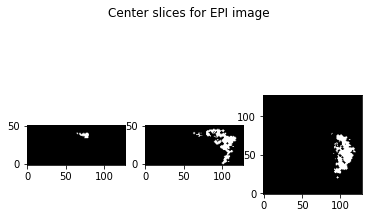

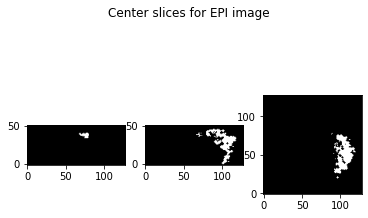

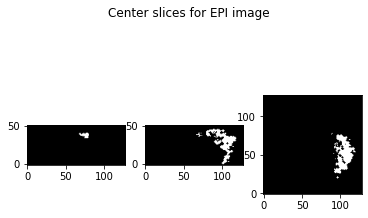

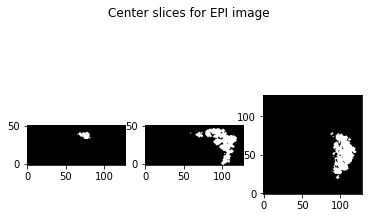

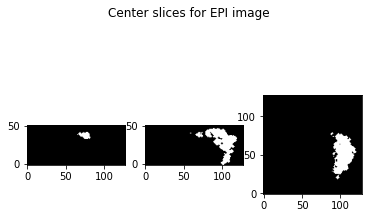

In [ ]:
my_show(liver_seg)
h = skimage.morphology.remove_small_objects(liver_seg,2)
my_show(h)
d2 = skimage.morphology.dilation(h)
my_show(d2)
b2 = skimage.morphology.binary_closing(d2)
my_show(b2)
r = post_processing(b2)
my_show(r)
d3 = skimage.morphology.dilation(r)
my_show(d3)
b3 = skimage.morphology.binary_closing(d3)
my_show(b3)


In [ ]:
  img_name = 'HardCase_2' + "_LIVER_Seg_0.06.nii.gz"
  #creating new NiftiImage
  new_nifti = nib.Nifti1Image(b3.astype('<f8'), ct_img.affine)
  #saving the nifti file.
  nib.save(new_nifti, img_name)

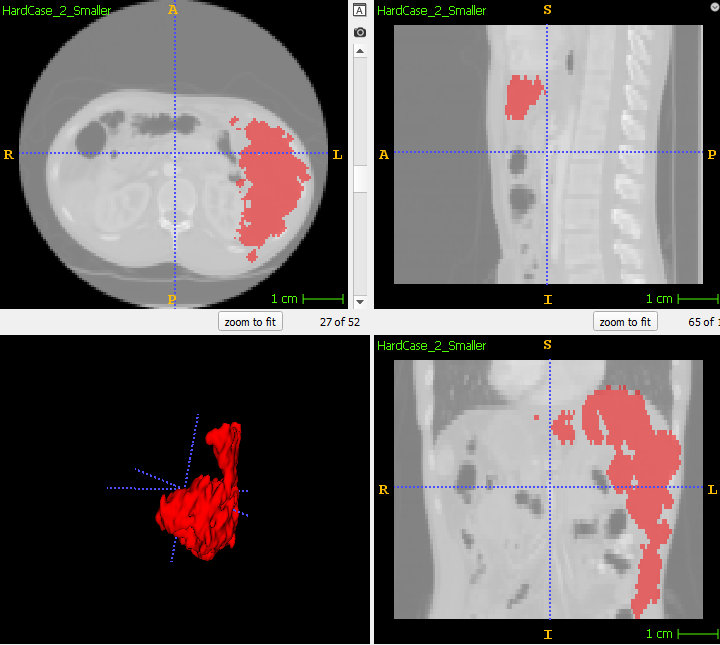

# Hard Case 3 Example

Isolate the patient’s body from the bed and the surroundings - no use of canonial

Image after thresholding
min size is  37125
Before morphologic operations   12
after remove_small_objects  1


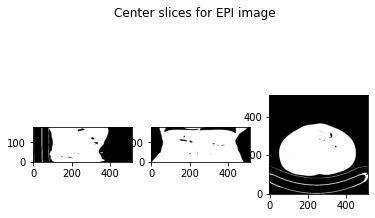

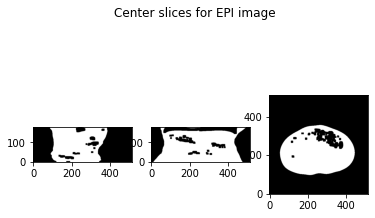

In [ ]:
nifty_file = 'HardCase3_CT'
IsolateBody_seg,img = IsolateBody(nifty_file)

Lungs segmentation from IsolateBS

0
32


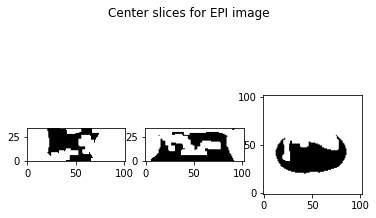

In [ ]:
BB_ind, CC_ind,widest_ind,lungs_seg = IsolateBS(IsolateBody_seg,nifty_file,img,True)

In [ ]:
print(BB_ind, CC_ind,widest_ind)

0 32 44


In [ ]:
ct_scan = 'HardCase3_CT'
aorta = 'HardCase3_Aorta'

In [ ]:
  aorta_img,ct_scan_img,ct_img = read_images(ct_scan,aorta)

(128, 128, 44)


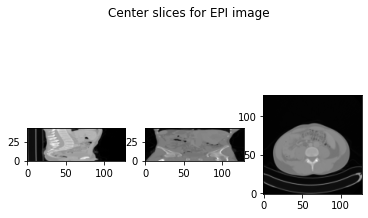

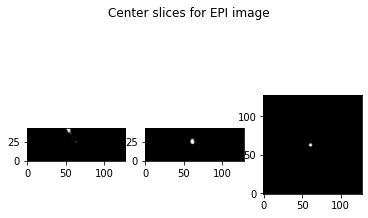

In [ ]:
h,w,d = ct_scan_img.shape
smaller_ct_img = resize(ct_scan_img, output_shape=(h//4, w//4, d//4), preserve_range=True)
smaller_aorta_img = resize(aorta_img, output_shape=(h//4, w//4, d//4), preserve_range=True)
my_show(smaller_ct_img)
my_show(smaller_aorta_img)
print(smaller_ct_img.shape)

In [ ]:
img_name = 'HardCase_3_Smaller' + ".nii.gz"
#creating new NiftiImage
new_nifti = nib.Nifti1Image(smaller_ct_img.astype('<f8'), ct_img.affine)
#saving the nifti file.
nib.save(new_nifti, img_name)

In [ ]:
liver_ROI = find_liver_ROI_Hard(smaller_ct_img,smaller_aorta_img,BB_ind , CC_ind,widest_ind)

57 127 0 127 0 32


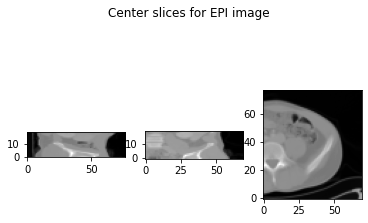

In [ ]:
minx,maxx,miny,maxy,minz,maxz=liver_ROI
my_show(smaller_ct_img[minx:maxx,miny+20:maxy-30,minz+10:maxz-2])

Delta is 0.1

128 128 44
Number  720896
seen:  48506
added  12764
added from seen :  0.26314270399538203


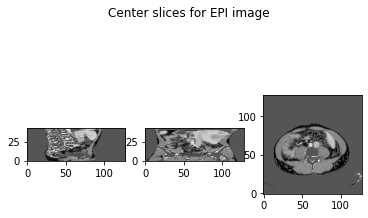

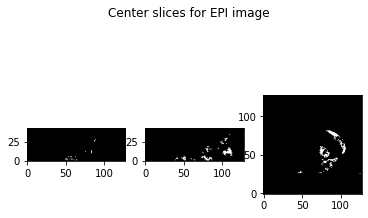

In [ ]:
liver_ROI = minx,maxx,miny+20,maxy-30,minz+10,maxz-2
liver_seg = multipleSeedsRG(smaller_ct_img, liver_ROI,0.1)

Delta is 0.09

128 128 44
Number  720896
seen:  33162
added  9490
added from seen :  0.28617091852119897


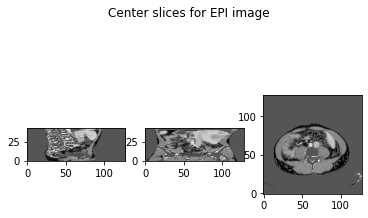

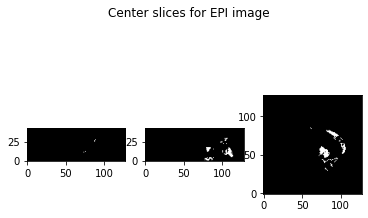

In [ ]:
liver_seg = multipleSeedsRG(smaller_ct_img, liver_ROI,0.09)

min size is  231
Before morphologic operations   4
after remove_small_objects  2


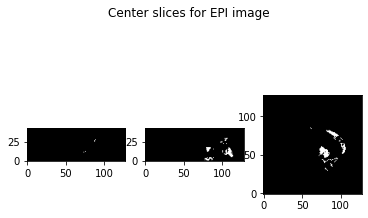

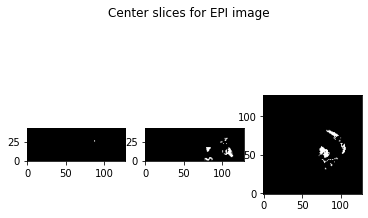

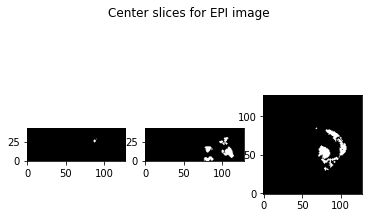

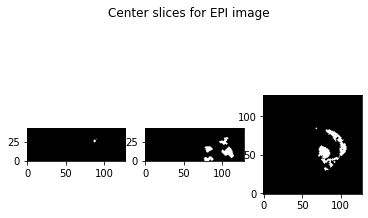

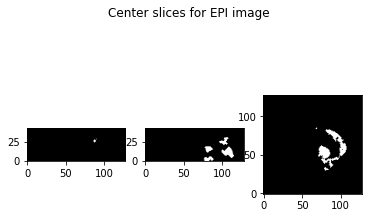

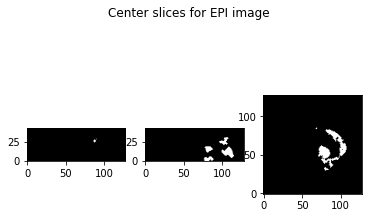

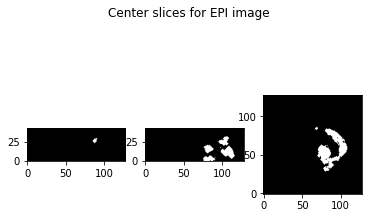

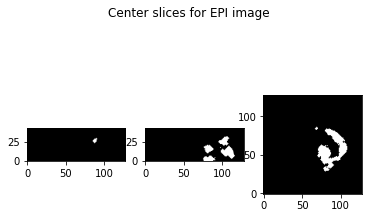

In [ ]:
my_show(liver_seg)
h = skimage.morphology.remove_small_objects(liver_seg,2)
my_show(h)
d2 = skimage.morphology.dilation(h)
my_show(d2)
b2 = skimage.morphology.binary_closing(d2)
my_show(b2)
r = post_processing(b2)
my_show(r)
d3 = skimage.morphology.dilation(r)
my_show(d3)
b3 = skimage.morphology.binary_closing(d3)
my_show(b3)


In [ ]:
  img_name = 'HardCase_3' + "_LIVER_Seg_0.09.nii.gz"
  #creating new NiftiImage
  new_nifti = nib.Nifti1Image(b3.astype('<f8'), ct_img.affine)
  #saving the nifti file.
  nib.save(new_nifti, img_name)

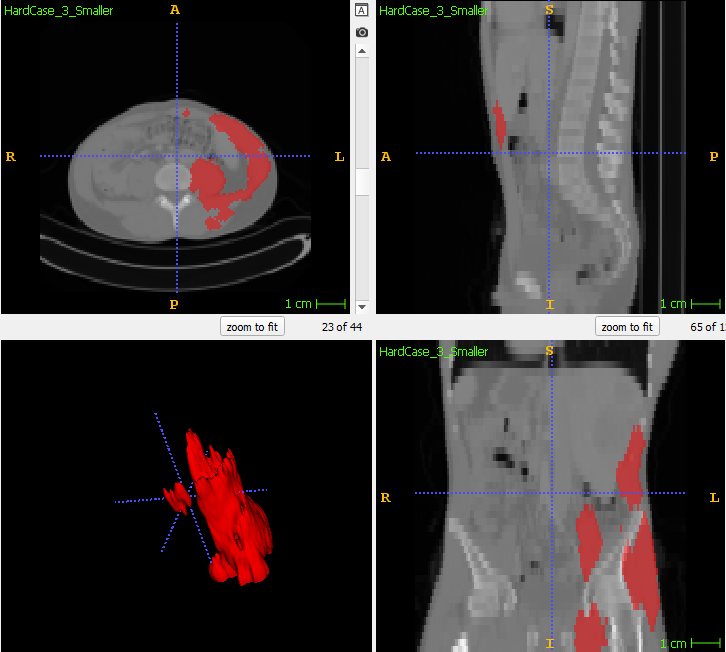

# Evaluation Metrics for the Segmentation

For this part of the exercise, you are provided with Ground Truth segmentation NIFTI files of the liver. To compare your results with the GT.
This function is given two segmentations, a GT one and an estimated one, and returns a tuple of (VOD_result, DICE_result). Use the definitions from the lecture slides.

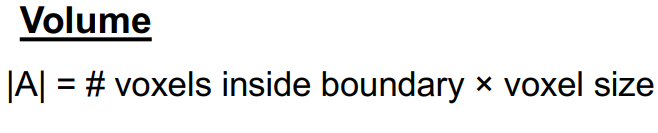

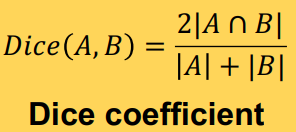

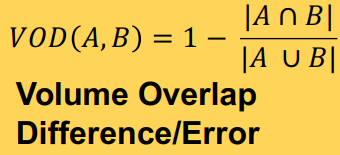

In [ ]:
def evaluateSegmentation(GT_seg, est_seg):
    GT_seg_img = nib.load(GT_seg)
    GT_seg_data = nib.as_closest_canonical(GT_seg_img)
    GT_seg = GT_seg_data.get_fdata()
    est_seg_img = nib.load(est_seg)
    # est_seg_data = nib.as_closest_canonical(est_seg_img)
    est_seg = est_seg_img.get_fdata()
    h,w,d = GT_seg.shape
    small_GT_seg = resize(GT_seg, output_shape=(h//3, w//3, d//3), preserve_range=True)
    my_show(small_GT_seg)
    print(np.count_nonzero(small_GT_seg))
    my_show(est_seg)
    GT_roi = ROI(small_GT_seg,est_seg)
    my_show(GT_roi)
    union = np.logical_or(GT_roi, est_seg)
    intersection = np.logical_and(GT_roi, est_seg)
    my_show(union)
    my_show(intersection)
    sum_intersection = np.sum(intersection)
    sum_union = np.sum(union)
    VOD_res = 1 - (sum_intersection / sum_union)
    DICE_res = (2 * sum_intersection) / (np.sum(GT_roi)+np.sum(est_seg))
    return VOD_res, DICE_res

In [ ]:
def ROI(GT_data,est_seg_data):
    s, c, a = np.nonzero(est_seg_data)
    roi = np.zeros_like(GT_data)
    roi[np.amin(s):np.amax(s), np.amin(c):np.amax(c), np.amin(a):np.amax(a)] = 1
    roi[GT_data<1]=0
    return roi

# Evaluation Results

Note :  the results are not as good as I expected. I tried different deltas for the homogenous function. As Leo metioned at the lecture, using std and mean for homogenous function will give regions with larger standard deviation a smaller penalty for being less similar to a voxels. So I thought that would be good for this case. I also considered that the seed selction might me the reason for those results, but I checked the ROI and it does covers the liver. I tried making it smaller or larger but again couldnt get better results. I even tried to choose a seed with automatic method (the one with the smallest gradient), but it wasnt representive after all.

Case 1 Results:

*   delta 0.165 VOD: 0.71 DICE: 0.44


Hard Case 1 Results:

*   delta 0.15 VOD: 0.79 DICE: 0.35
*   delta 0.09 VOD: 0.69 DICE: 0.46 
*   delta 0.06 VOD: 0.66 DICE: 0.5



Case 1

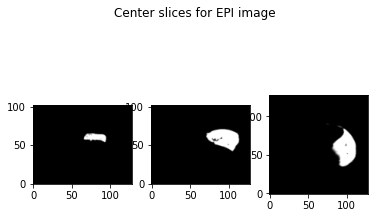

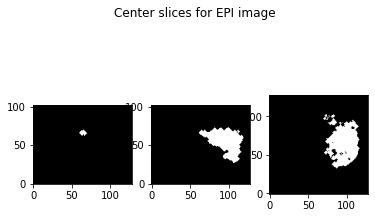

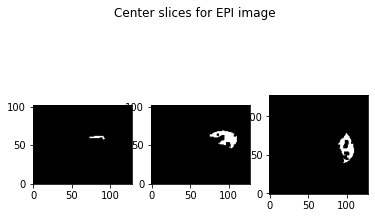

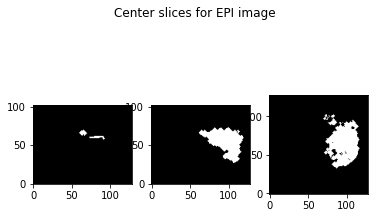

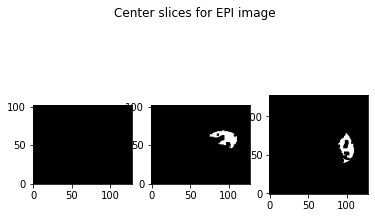

In [ ]:
est_seg = '/content/Case_1_Smaller_LIVER_Seg_.nii.gz'
GT_seg = '/content/gdrive/MyDrive/Targil1_data/Case1_liver_segmentation.nii.gz'
VOD_res, DICE_res = evaluateSegmentation(GT_seg, est_seg)

In [ ]:
print(VOD_res, DICE_res)

0.716802939350031 0.44139293851954914


Hard Case 1 delta 0.15

55521


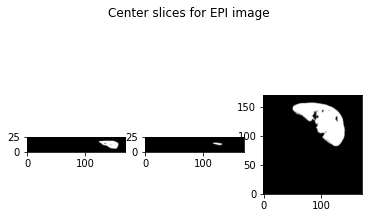

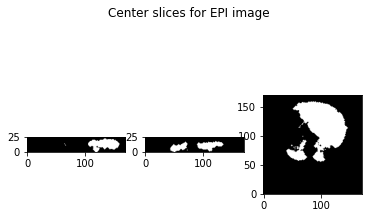

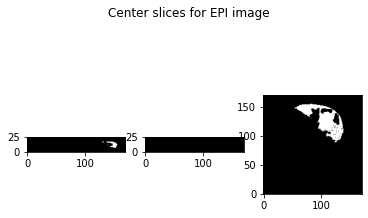

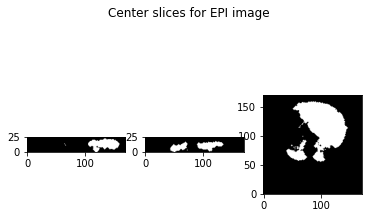

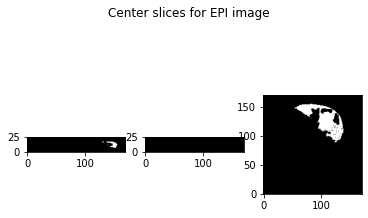

In [ ]:
est_seg = '/content/HardCase_1_LIVER_Seg_.nii.gz'
GT_seg = '/content/gdrive/MyDrive/Targil1_data/HardCase1_liver_segmentation.nii.gz'
VOD_res, DICE_res = evaluateSegmentation(GT_seg, est_seg)

In [ ]:
print(VOD_res, DICE_res)

0.7900501274530132 0.3470389597298523


Hard Case 1 delta 0.09

55521


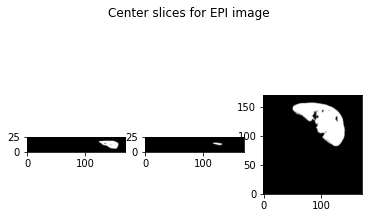

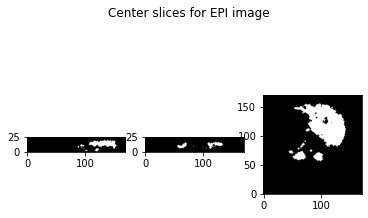

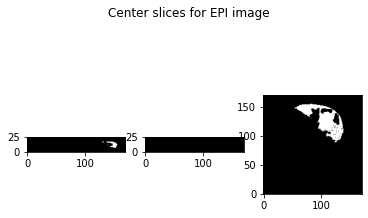

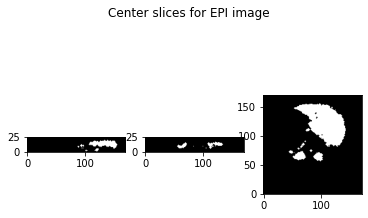

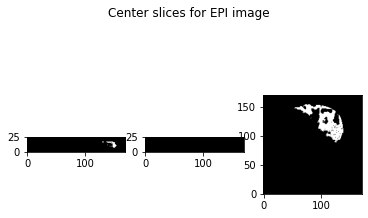

In [ ]:
# est_seg = '/content/HardCase_1_LIVER_Seg_.nii.gz'
est_seg = '//content/HardCase_1_LIVER_Seg_0.09.nii.gz'
GT_seg = '/content/gdrive/MyDrive/Targil1_data/HardCase1_liver_segmentation.nii.gz'
VOD_res, DICE_res = evaluateSegmentation(GT_seg, est_seg)

In [ ]:
print(VOD_res, DICE_res)

0.6987363762331189 0.46303242212333123


Hard Case 1 delta 0.06

55521


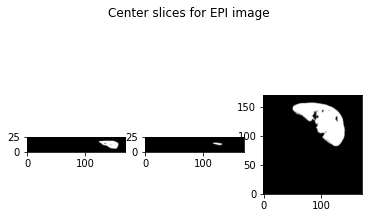

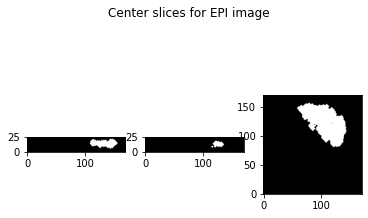

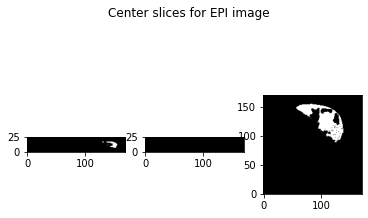

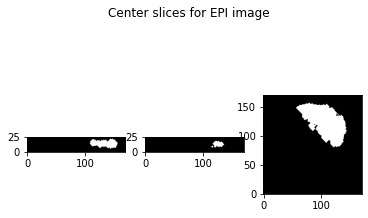

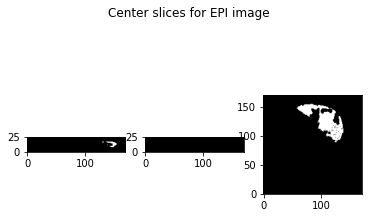

In [ ]:
est_seg = '/content/HardCase_1_LIVER_Seg_0.06.nii.gz'
GT_seg = '/content/gdrive/MyDrive/Targil1_data/HardCase1_liver_segmentation.nii.gz'
VOD_res, DICE_res = evaluateSegmentation(GT_seg, est_seg)

In [ ]:
print(VOD_res, DICE_res)

0.6627500165027395 0.5043933260933952


# MSRG Liver Segmentation

 Finally, implement the following fully-automated function:
segmentLiver
Input: 1) CT nifti file name; 2) aorta segmentation nifti file name; 3) output file name
Output: liver segmentation nifti file (to be saved under the given name)

In [ ]:
def segmentLiver(ct_scan,aorta_seg,isHard,resize_by,delta):
    """This function gets as input a path to ct scan, a path to aorta segmatation,
    a boolean flag if this is a hard case to create to proper ROI and morphological
    operations. It also gets a size to reduce to image to and a delta tp check similarity.
    It returns a liver segmentation, and saves it."""
    IsolateBody_seg,img = IsolateBody(ct_scan)
    BB_ind, CC_ind,widest_ind,lungs_seg = IsolateBS(IsolateBody_seg,ct_scan,img,True,resize_by)
    # read images
    aorta_img,ct_scan_img,ct_img = read_images(ct_scan,aorta_seg)
    h,w,d = ct_scan_img.shape
    # resize
    smaller_ct_img = resize(ct_scan_img, output_shape=(h//resize_by, w//resize_by, d//resize_by), preserve_range=True)
    smaller_aorta_img = resize(aorta_img, output_shape=(h//resize_by, w//resize_by, d//resize_by), preserve_range=True)
    my_show(smaller_ct_img)
    if isHard:
      ROI = find_liver_ROI_Hard(smaller_ct_img,smaller_aorta_img,BB_ind , CC_ind,widest_ind)
    else:
      ROI = find_liver_ROI(smaller_ct_img,smaller_aorta_img,BB_ind , CC_ind,widest_ind)
    min_x,max_x,min_y,max_y,min_z,max_z=ROI
    liver_seg = multipleSeedsRG(smaller_ct_img, ROI, delta)
    if isHard:
      h = skimage.morphology.remove_small_objects(liver_seg,2)
      d2 = skimage.morphology.dilation(h)
      b2 = skimage.morphology.binary_closing(d2)
      r = post_processing(b2)
      d3 = skimage.morphology.dilation(r)
      b3 = skimage.morphology.binary_closing(d3)
      d4 = skimage.morphology.dilation(b3)
      b4 = skimage.morphology.binary_closing(d4)
      d5 = skimage.morphology.dilation(b4)
      b5 = skimage.morphology.binary_closing(d5)
      img_name =  ct_scan + "_liver_Seg.nii.gz"
      #creating new NiftiImage
      new_nifti = nib.Nifti1Image(b5.astype('<f8'), ct_img.affine)
      #saving the nifti file.
      nib.save(new_nifti, img_name)
      return b5
    else:
      d = skimage.morphology.dilation(liver_seg)
      b = skimage.morphology.binary_closing(d)
      r = post_processing(b)
      img_name =  ct_scan + "_liver_Seg.nii.gz"
      #creating new NiftiImage
      new_nifti = nib.Nifti1Image(r.astype('<f8'), ct_img.affine)
      #saving the nifti file.
      nib.save(new_nifti, img_name)
      return r


#HardCase 1 exmaple


Image after thresholding
min size is  54937
Before morphologic operations   3
after remove_small_objects  1
9
19
68 169 0 169 0 19
170 170 26
Number  751400
seen:  32155
added  5070
added from seen :  0.1576737676877624
min size is  287
Before morphologic operations   17
after remove_small_objects  3


array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

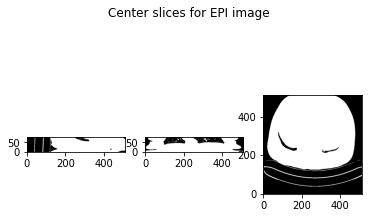

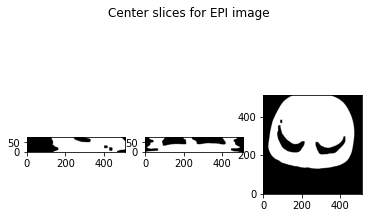

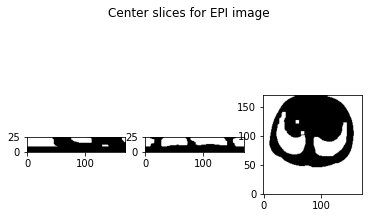

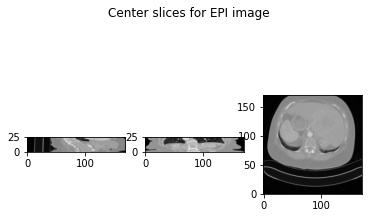

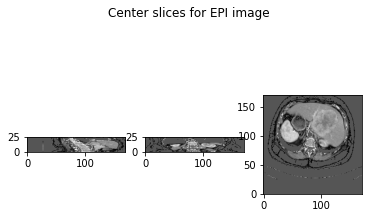

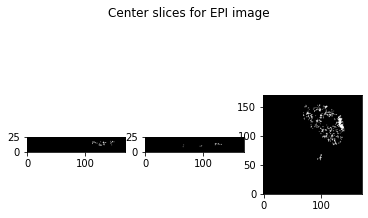

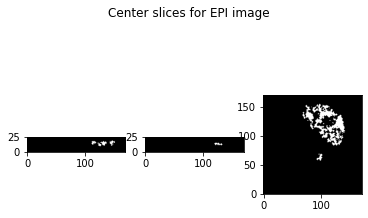

In [ ]:
ct_scan = 'HardCase1_CT'
aorta_seg = 'HardCase1_Aorta'
segmentLiver(ct_scan,aorta_seg,isHard = True ,resize_by = 3 ,delta = 0.06)